In [1]:
%%capture
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'png' 

import matplotlib.lines as mlines
import seaborn
matplotlib.rcParams['figure.figsize'] = (12.0, 3.0)
matplotlib.rcParams['font.size'] = 7
seaborn.set_style('darkgrid')

from braindecode.scripts.print_results import ResultPrinter
from braindecode.csp.print_results import CSPResultPrinter
import logging
log = logging.getLogger()
log.setLevel("DEBUG")


## New with Pandas

In [2]:
from braindecode.analysis.stats import perm_mean_diff_test
import pandas as pd
from braindecode.analysis.pandas_util import round_numeric_columns
from braindecode.analysis.stats import wilcoxon_signed_rank, sign_test


In [3]:
from braindecode.analysis.pandas_util import restrict, restrict_or_unset, restrict_or_missing_col
from braindecode.paper.results import * 

In [4]:
from braindecode.analysis.pandas_util import (load_data_frame,
                                              dataset_averaged_frame,
                                              remove_columns_with_same_value,
                                              remove_indices_with_same_value)

df_csp_ours = load_data_frame('data/models/paper/ours/csp/', shorten_headers=False)
df_csp_bcic = load_data_frame('data/models/paper/bci-competition/csp/', shorten_headers=False)
df_deep_cnt_ours = load_data_frame('data/models/paper/ours/cnt/deep4/', shorten_headers=False)
df_deep_cnt_bcic = load_data_frame('data/models/paper/bci-competition/cnt/deep4/', shorten_headers=False)
df_shallow_cnt_ours = load_data_frame('data/models/paper/ours/cnt/shallow//', shorten_headers=False)
df_shallow_cnt_bcic = load_data_frame('data/models/paper/bci-competition/cnt/shallow//', shorten_headers=False)

df_deep_epo_ours = load_data_frame('data/models/paper/ours/epo/deep4/', shorten_headers=False)
df_deep_epo_bcic = load_data_frame('data/models/paper/bci-competition/epo/deep4/', shorten_headers=False)
df_shallow_epo_ours = load_data_frame('data/models/paper/ours/epo/shallow//', shorten_headers=False)
df_shallow_epo_bcic = load_data_frame('data/models/paper/bci-competition/epo/shallow//', shorten_headers=False)

In [5]:
from braindecode.paper.results import clean_datasets
def add_p_vals_to_df_row(df, test_a, test_b, n_diffs_for_large=2**20):
    assert len(test_a) == len(test_b)
    if len(test_a) > 20:
        assert len(test_a) == 29 or len(test_a) == 23
        p_val = perm_mean_diff_test(test_a,test_b, n_diffs=n_diffs_for_large)
    else:
        assert len(test_a) == 9 or len(test_a) == 20 or len(test_a) == 14 
        p_val = perm_mean_diff_test(test_a,test_b)
    p_val_wilc = wilcoxon_signed_rank(test_a, test_b)
    p_val_sign = sign_test(test_a, test_b)
    df['rand'] = p_val
    df['wilc'] = p_val_wilc
    df['sign'] = p_val_sign    

## Validation CSP

In [6]:
def csp_no_standardize(df):
    df = df[((df.standardize_filt_cnt == False) | (df.standardize_filt_cnt == '-')) &
           ((df.standardize_epo == False) | (df.standardize_epo == '-')) &
           ((df.standardize_cnt == False) | (df.standardize_cnt == '-')) &
           ((df.standardize == False) | (df.standardize == '-'))]
    return df

def csp_no_standardize_new(df):
    df = csp_no_standardize(df)
    df = df[df.standardize == '-']
    return df

In [7]:
df_valid = df_csp_bcic.copy()
df_valid = df_valid[(df_valid.resample_fs == 250) & (df_valid.max_freq == 34) & (df_valid.min_freq == 7)]
df_valid = df_valid[df_valid.low_bound == 0]
df_valid = df_valid.sort_values(by='dataset_filename')

dataset_averaged_frame(remove_columns_with_same_value(df_valid))

time                    test       train     
                        len    tmean     tstd  mean   std  mean  std
trial_stop trial_start                                              
2500        500           9 00:00:33 00:00:01  67.6  15.1  93.6  4.1
4000       -500           9 00:00:44 00:00:01  57.1  10.3  88.9  6.6
            0             9 00:00:41 00:00:01  61.3  14.3  90.3  6.2
            500           9 00:00:39 00:00:01  67.8  15.9  92.6  5.2

In [8]:
test_val_theirs = [79.16,52.08,83.33,62.15,54.51,39.24,83.33,82.64,66.67]

test_val_ours_2500 = df_valid[df_valid.trial_stop == 2500].test

df = pd.DataFrame()
df['test_theirs'] = [np.mean(test_val_theirs)]
df['test_ours'] = [np.mean(test_val_ours_2500)]
df['diff'] = [np.mean(test_val_ours_2500) - np.mean(test_val_theirs)]
df = round_numeric_columns(df, 2)
add_p_vals_to_df_row(df, test_val_theirs, test_val_ours_2500)
df

,test_theirs,test_ours,diff,rand,wilc,sign
0,67.01,67.59,0.58,0.78125,0.734375,1


In [9]:
test_val_ours_4000 = df_valid[(df_valid.trial_stop == 4000) & (df_valid.trial_start == 500)].test

df = pd.DataFrame()
df['test_theirs'] = [np.mean(test_val_theirs)]
df['test_ours'] = [np.mean(test_val_ours_4000)]
df['diff'] = [np.mean(test_val_ours_4000) - np.mean(test_val_theirs)]
df = round_numeric_columns(df, 2)
add_p_vals_to_df_row(df, test_val_theirs, test_val_ours_4000)
df

,test_theirs,test_ours,diff,rand,wilc,sign
0,67.01,67.82,0.81,0.757812,0.734375,1


## Main comparison

In [32]:
from braindecode.paper.results import *
all_df = pd.DataFrame()
for dataset in ('bcic', 'ours'):
    for net in 'shallow', 'deep5':
        for training in 'epo', 'cnt':
            for band in ['>0', '>4', '0-4']:
                for clean in (True, False):
                    for trial_start in (-500,0,500):
                        if training == 'cnt':
                            trial_start_net = trial_start + 2000
                        else:
                            trial_start_net = trial_start
                        if dataset == 'bcic':
                            dfc = df_csp_bcic
                        else:
                            assert dataset == 'ours'
                            dfc = df_csp_ours
                        if dataset == 'bcic' and net == 'shallow' and training == 'cnt':
                            dfn = df_shallow_cnt_bcic
                        elif dataset == 'bcic' and net == 'shallow' and training == 'epo':
                            dfn = df_shallow_epo_bcic
                        elif dataset == 'bcic' and net == 'deep5' and training == 'cnt':
                            dfn = df_deep_cnt_bcic
                        elif dataset == 'bcic' and net == 'deep5' and training == 'epo':
                            dfn = df_deep_epo_bcic
                        elif dataset == 'ours' and net == 'shallow' and training == 'cnt':
                            dfn = df_shallow_cnt_ours
                        elif dataset == 'ours' and net == 'shallow' and training == 'epo':
                            dfn = df_shallow_epo_ours
                        elif dataset == 'ours' and net == 'deep5' and training == 'cnt':
                            dfn = df_deep_cnt_ours
                        elif dataset == 'ours' and net == 'deep5' and training == 'epo':
                            dfn = df_deep_epo_ours
                        else:
                            raise ValueError("Unknown combination")
                        if clean:
                            dfn = clean_datasets(dfn)
                            dfc = clean_datasets(dfc)

                        if band == '>0':
                            this_dfn = above_0(dfn)
                            this_dfc = csp_above_0(dfc)
                        elif band == '>4':
                            this_dfn = above_4(dfn)
                            this_dfc = csp_above_4(dfc)
                        elif band == '0-4':
                            this_dfn = from_0_to_4(dfn)
                            this_dfc = csp_0_to_4(dfc)
                        

                        if net == 'deep5' and training == 'epo':
                            this_dfn = deep5_main_comp(this_dfn)
                        elif net == 'deep5' and training == 'cnt':
                            this_dfn = deep5_cnt_main_comp(this_dfn)
                        elif net =='shallow' and training == 'epo':
                            this_dfn = shallow_main_comp(this_dfn)
                        elif net =='shallow' and training == 'cnt':
                            this_dfn = shallow_cnt_main_comp(this_dfn)
                        else:
                            raise ValueError("Unknown combination")
                        
                        
                        this_dfc = main_comp_csp(this_dfc)
                        this_dfn = this_dfn[this_dfn.trial_start == trial_start_net]
                        this_dfc = this_dfc[this_dfc.trial_start == trial_start]
                        this_dfn = restrict_if_existing_and_not_unique(this_dfn, variant='b')
                        if training == 'epo':
                            this_dfn = this_dfn[this_dfn.max_increasing_epochs == 160]
                            this_dfn = restrict_if_existing_and_not_unique(this_dfn, monitors='trial_monitors')
                        else:
                            assert training == 'cnt'
                            this_dfn = this_dfn[this_dfn.max_increasing_epochs == 80]

                        if dataset == 'bcic' and net == 'deep5' and (
                            training == 'epo' or (band == '>0' or band == '>4')):
                            this_dfn = this_dfn[this_dfn.layers == 'deep_5']


                        if dataset == 'bcic':
                            assert len(this_dfc) == 9, "wrong length: {:d} ({:s})".format(
                                len(this_dfc), str((dataset, net, training, band, clean)))
                            assert len(this_dfn) == 9, "wrong length: {:d} ({:s})".format(
                                len(this_dfn), str((dataset, net, training, band, clean)))
                        elif dataset == 'ours' and clean:
                            assert len(this_dfc) == 14, "wrong length: {:d} ({:s})".format(
                                len(this_dfc), str((dataset, net, training, band, clean)))
                            assert len(this_dfn) == 14, "wrong length: {:d} ({:s})".format(
                                len(this_dfn), str((dataset, net, training, band, clean)))
                        elif dataset == 'ours' and (not clean):
                            assert len(this_dfc) == 20, "wrong length: {:d} ({:s})".format(
                                len(this_dfc), str((dataset, net, training, band, clean)))
                            assert len(this_dfn) == 20, "wrong length: {:d} ({:s})".format(
                                len(this_dfn), str((dataset, net, training, band, clean)))
                        else:
                            raise ValueError("Unknown combination")


                        this_dfn = remove_columns_with_same_value(this_dfn)
                        this_dfn['clean'] = clean
                        this_dfn['net'] = net
                        this_dfn['train_type'] = training
                        this_dfn['freq'] = band
                        this_dfn['dataset'] = dataset
                        this_dfn['trial_start'] = trial_start

                        all_df = all_df.append(this_dfn)
                        if net == 'shallow' and training == 'epo': # only add csp once, not several times => for both nets :))
                            this_dfc = remove_columns_with_same_value(this_dfc)
                            this_dfc['clean'] = clean
                            this_dfc['net'] = 'csp'
                            this_dfc['freq'] = band
                            this_dfc['train_type'] = training
                            this_dfc['dataset'] = dataset
                            this_dfc['trial_start'] = trial_start
                            all_df = all_df.append(this_dfc)

In [31]:
def restrict_if_existing_and_not_unique(df, **params):
    for key, val in params.iteritems():
        if (key in df.columns) and (len(df[key].unique()) > 1):
            df = df[df[key] == val]
    return df

In [ ]:

AssertionError: wrong length: 0 (('bcic', 'shallow', 'epo', '>0', True))

,drop_p,cleaner,updates_expression,batch_modifier,iterator,high_cut_hz,batch_norm_alpha,pool_time_stride,dataset,marker_def,...,pool_time_length,valid_set_fraction,num_filters,num_cv_folds,max_abs_threshold,updates_modifier,preprocessor,time,test,train
90,0.5,no_cleaner,adam,null,balanced_batch_iterator,38,0.1,15,cleaned_combined_set,markers_4_class,...,75,0.2,40,5,800,max_norm_modifier,null,00:07:07,81.597222,100
114,0.5,no_cleaner,adam,null,balanced_batch_iterator,38,0.1,15,cleaned_combined_set,markers_4_class,...,75,0.2,40,5,800,max_norm_modifier,null,00:02:37,46.527778,100
138,0.5,no_cleaner,adam,null,balanced_batch_iterator,38,0.1,15,cleaned_combined_set,markers_4_class,...,75,0.2,40,5,800,max_norm_modifier,null,00:06:49,92.013889,100
162,0.5,no_cleaner,adam,null,balanced_batch_iterator,38,0.1,15,cleaned_combined_set,markers_4_class,...,75,0.2,40,5,800,max_norm_modifier,null,00:06:30,63.888889,100
186,0.5,no_cleaner,adam,null,balanced_batch_iterator,38,0.1,15,cleaned_combined_set,markers_4_class,...,75,0.2,40,5,800,max_norm_modifier,null,00:06:02,70.833333,100
210,0.5,no_cleaner,adam,null,balanced_batch_iterator,38,0.1,15,cleaned_combined_set,markers_4_class,...,75,0.2,40,5,800,max_norm_modifier,null,00:03:07,54.166667,100
234,0.5,no_cleaner,adam,null,balanced_batch_iterator,38,0.1,15,cleaned_combined_set,markers_4_class,...,75,0.2,40,5,800,max_norm_modifier,null,00:11:26,86.111111,100
258,0.5,no_cleaner,adam,null,balanced_batch_iterator,38,0.1,15,cleaned_combined_set,markers_4_class,...,75,0.2,40,5,800,max_norm_modifier,null,00:04:32,83.333333,100
282,0.5,no_cleaner,adam,null,balanced_batch_iterator,38,0.1,15,cleaned_combined_set,markers_4_class,...,75,0.2,40,5,800,max_norm_modifier,null,00:06:36,81.250000,100


In [33]:
# 3 * due to -500, 0, 500 trial start
assert len(all_df) == 3 * (15 * 29 + 15 * 23)

## Show plots wihtout significance for now

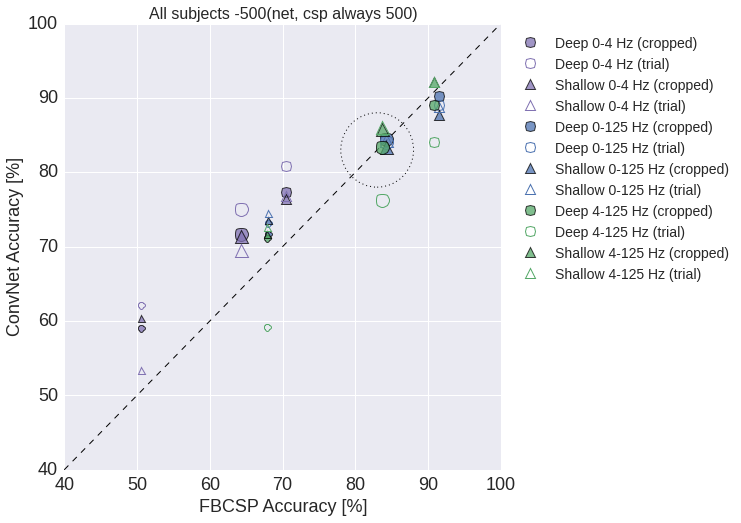

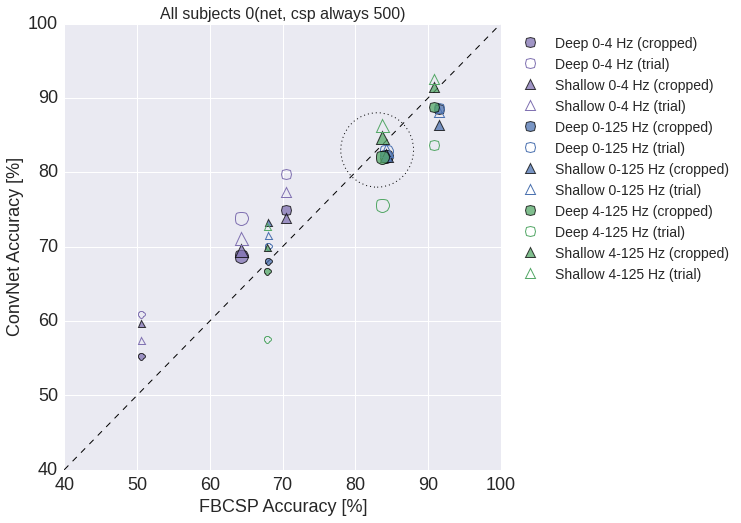

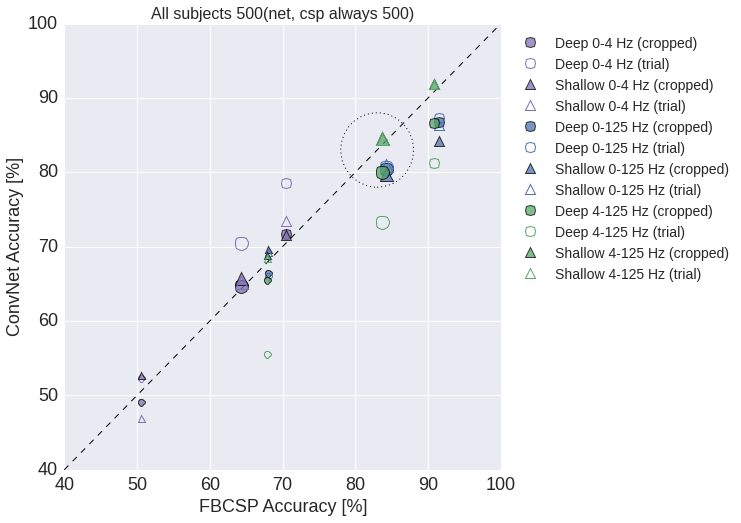

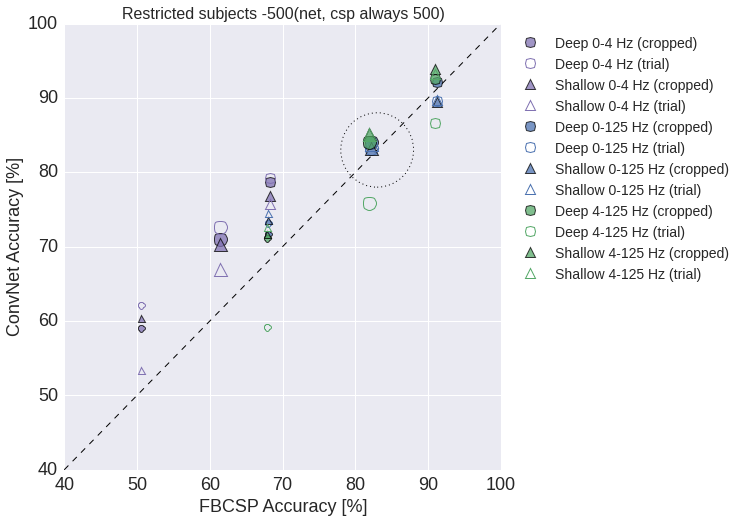

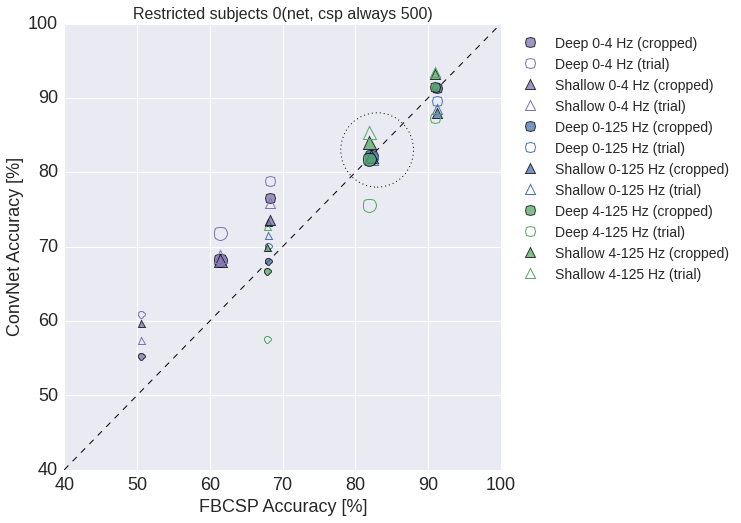

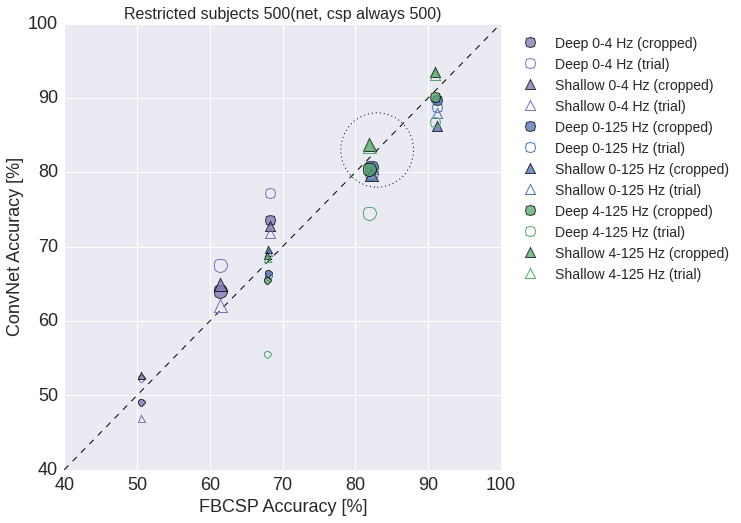

In [174]:
%config InlineBackend.figure_format = 'png' 

for clean in (False, True):
    for trial_start in (-500,0,500):
        fig = plt.figure(figsize=(7,7))

        plt.plot([40,100], [40,100], color='black', label='', linestyle='--', lw=1)

        all_labels = []
        sig_count_strong = []
        sig_count_weak = []
        for dataset in ('bcic', 'ours', 'combined'):
            for freq in ('0-4', '>0', '>4'):
                for net in ('deep5', 'shallow'):
                    for train_type in ('cnt', 'epo',):
                        this_row_net = all_df[(all_df.freq == freq) &
                                               (all_df.train_type == train_type) &
                                               (all_df.net == net) &
                                                (all_df.clean == clean) &
                                         (all_df.trial_start == trial_start)]
                        this_row_csp = all_df[(all_df.freq == freq) &
                                               (all_df.net == 'csp') &
                                                (all_df.clean == clean) &
                                         (all_df.trial_start == 500)]
                        if dataset != 'combined':
                            this_row_csp = this_row_csp[this_row_csp.dataset == dataset]
                            this_row_net = this_row_net[this_row_net.dataset == dataset]
                        if net == 'deep5':
                            marker = 'o'
                        else:
                            assert net == 'shallow'
                            marker = '^'
                        if '>0' == freq:
                            color = seaborn.color_palette()[0]
                        elif '>4' == freq:
                            color = seaborn.color_palette()[1]
                        else:
                            assert freq == '0-4'
                            color = seaborn.color_palette()[3]
                        markerfacecolor = 'None'
                        if 'bcic' == dataset:
                            markersize=7
                        elif 'ours' == dataset:
                            markersize=10
                        elif 'combined' == dataset:
                            markersize=13 

                        markerfacecolor = 'None'
                        markeredgecolor = color
                        if 'cnt' == train_type:
                            markerfacecolor = color + (0.75,) # some alpha
                            markeredgecolor = 'black'

                        test_csp = np.mean(this_row_csp.test)
                        test_net = np.mean(this_row_net.test)


                        plt.plot(test_csp, test_net, color=color, 
                                 marker=marker, linestyle='None', markersize=markersize, label='dummy',
                                markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor,
                                markeredgewidth=1)




        plt.xlabel('FBCSP Accuracy [%]', fontsize=18)

        plt.ylabel('ConvNet Accuracy [%]', fontsize=18)

        circle = plt.Circle((83,83), 5, facecolor='None', linestyle='dotted', linewidth=1)
        plt.gca().add_artist(circle)


        ax = plt.gca()
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[12:30], (
                                   'Deep 0-4 Hz (cropped)', 
                                   'Deep 0-4 Hz (trial)',
                                   'Shallow 0-4 Hz (cropped)',
                                   'Shallow 0-4 Hz (trial)',
                                   'Deep 0-125 Hz (cropped)', 
                                   'Deep 0-125 Hz (trial)',
                                   'Shallow 0-125 Hz (cropped)',
                                   'Shallow 0-125 Hz (trial)',
                                   'Deep 4-125 Hz (cropped)', 
                                   'Deep 4-125 Hz (trial)',
                                   'Shallow 4-125 Hz (cropped)',
                                   'Shallow 4-125 Hz (trial)',),
                  bbox_to_anchor=(1.55,1),fontsize=14)

        plt.tight_layout()

        # We change the fontsize of minor ticks label 
        plt.gca().tick_params(axis='both', which='major', labelsize=18)
        clean_str = 'Restricted subjects' if clean else 'All subjects'
        plt.title('{:s} {:d} (net, csp always 500)'.format(clean_str, trial_start), fontsize=16)


### Plot overall stuff

##### Make comparisons

In [42]:
# lets reduce to proper comparison
all_df = all_df[((all_df.net != 'csp') & (all_df.trial_start == -500)) |
      ((all_df.net == 'csp') & (all_df.trial_start == 500))]

In [43]:

all_compared = pd.DataFrame()
param_keys = ['dataset', 'freq', 'net',  'train_type', 'clean']
all_groups = all_df.groupby(param_keys)

for name, group in all_groups:
    assert len(group['freq'].unique()) == 1
    freq = group['freq'].iloc[0]
    assert len(group['dataset'].unique()) == 1
    dataset = group['dataset'].iloc[0]
    assert len(group['net'].unique()) == 1
    net = group['net'].iloc[0]
    assert len(group['clean'].unique()) == 1
    clean = group['clean'].iloc[0]
    assert len(group['train_type'].unique()) == 1
    train_type = group['train_type'].iloc[0]
    if net == 'csp': continue
    csp = all_df[(all_df.net == 'csp') & (all_df.freq == freq) &
                (all_df.dataset == dataset) &
                (all_df.clean == clean)]
    df_compare = compare_csp_net(group, csp, net, freq, dataset, with_csp_acc=True, with_std=True,
                                with_std_error=True)   
    df_compare['clean'] = clean
    df_compare['train_type'] = train_type
    all_compared = all_compared.append(df_compare)

##### Add combined set comparisons

##### look at jitter plot

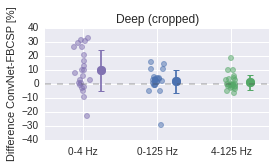

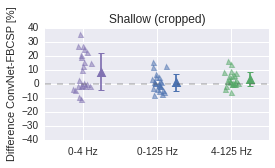

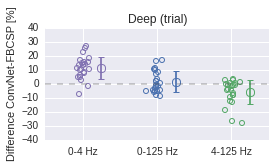

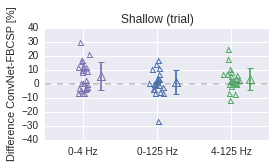

In [45]:
from numpy.random import RandomState

param_keys = ['freq', 'net',  'train_type', 'clean']
all_groups = all_df.groupby(param_keys)

all_test_net = []
all_test_csp = []
rng = RandomState(394834)
for wanted_train_type in ('cnt', 'epo'):
    for wanted_net in ('deep5', 'shallow'):
        plt.figure(figsize=(4,2))
        
        offset = 0
        for name, group in all_groups:
            assert len(group['freq'].unique()) == 1
            freq = group['freq'].iloc[0]
            assert len(group['net'].unique()) == 1
            net = group['net'].iloc[0]
            assert len(group['clean'].unique()) == 1
            clean = group['clean'].iloc[0]
            assert len(group['train_type'].unique()) == 1
            train_type = group['train_type'].iloc[0]
            if clean == False: continue
            if net == 'csp': continue
            if net != wanted_net: continue
            if train_type != wanted_train_type: continue
            csp = all_df[(all_df.net == 'csp') & (all_df.freq == freq) &
                        (all_df.clean == clean)]
            assert (len(csp) == 29 and not clean) or (len(csp) == 23 and clean)
            df_merged = group.merge(csp, on='dataset_filename', suffixes=('_net','_csp'))

            test_acc_net = np.array(df_merged['test_net'])
            test_acc_csp = np.array(df_merged['test_csp'])
            all_test_net.append(test_acc_net)
            all_test_csp.append(test_acc_csp)
            diffs = test_acc_net - test_acc_csp
            if net == 'deep5':
                marker = 'o'
            else:
                assert net == 'shallow'
                marker = '^'
            if '>0' == freq:
                color = seaborn.color_palette()[0]
            elif '>4' == freq:
                color = seaborn.color_palette()[1]
            else:
                assert freq == '0-4'
                color = seaborn.color_palette()[3]
            markerfacecolor = 'None'
            if 'cnt' == train_type:
                markerfacecolor = color

            plt.plot(
                    rng.randn(len(diffs)) * 0.05 + offset,
                        diffs, color=color, marker=marker, alpha=0.5, linestyle='None',
                    markersize=5,markeredgecolor=color, markerfacecolor=markerfacecolor, 
                     markeredgewidth=1)
            plt.errorbar(offset+0.25, np.mean(diffs), yerr=np.std(diffs), ecolor=color,
                     marker=marker, linestyle='None',
                markersize=8,markeredgecolor=color, markerfacecolor=markerfacecolor, 
                             markeredgewidth=1)
            offset += 1
            #plt.xlabel('FBCSP Accuracy [%]')
        plt.ylabel('Difference ConvNet-FBCSP [%]')
        plt.ylim(-40,40)
        plt.axhline(y=0, linestyle='--', color=(0.3,0.3,0.3,0.3))
        plt.xticks(range(0,3), ['0-4 Hz', '0-125 Hz', '4-125 Hz'])
        title_str = wanted_net.strip('5').capitalize()
        if wanted_train_type == 'cnt':
            title_str += " (cropped)"
        else:
            assert wanted_train_type == 'epo'
            title_str += " (trial)"
        plt.title(title_str)


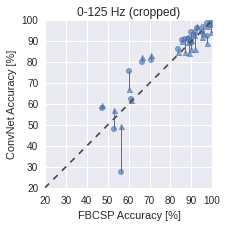

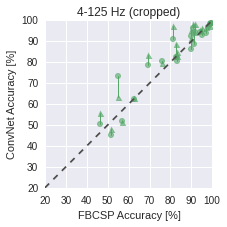

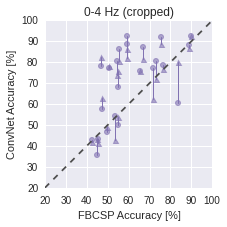

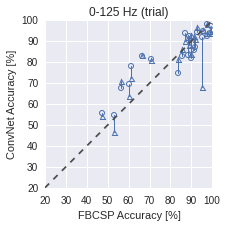

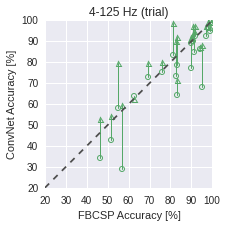

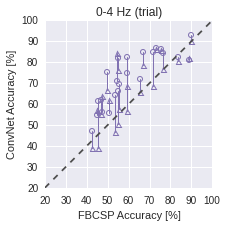

In [49]:
from numpy.random import RandomState

param_keys = ['freq', 'net',  'train_type', 'clean']
all_groups = all_df.groupby(param_keys)

all_test_net = []
all_test_csp = []
rng = RandomState(394834)
for wanted_train_type in ('cnt', 'epo'):
    for wanted_freq in ('>0', '>4', '0-4'):
        plt.figure(figsize=(3,3))
        
        offset = 0
        net_accs_before = None
        for name, group in all_groups:
            assert len(group['freq'].unique()) == 1
            freq = group['freq'].iloc[0]
            assert len(group['net'].unique()) == 1
            net = group['net'].iloc[0]
            assert len(group['clean'].unique()) == 1
            clean = group['clean'].iloc[0]
            assert len(group['train_type'].unique()) == 1
            train_type = group['train_type'].iloc[0]
            if clean == False: continue
            if net == 'csp': continue
            if freq != wanted_freq: continue
            if train_type != wanted_train_type: continue
            csp = all_df[(all_df.net == 'csp') & (all_df.freq == freq) &
                        (all_df.clean == clean)]
            assert (len(csp) == 29 and not clean) or (len(csp) == 23 and clean)
            csp = csp.sort_values(by='dataset_filename')
            group = group.sort_values(by='dataset_filename')
            df_merged = group.merge(csp, on='dataset_filename', suffixes=('_net','_csp'))

            test_acc_net = np.array(df_merged['test_net'])
            test_acc_csp = np.array(df_merged['test_csp'])
            all_test_net.append(test_acc_net)
            all_test_csp.append(test_acc_csp)
            diffs = test_acc_net - test_acc_csp
            if net == 'deep5':
                marker = 'o'
            else:
                assert net == 'shallow'
                marker = '^'
            if '>0' == freq:
                color = seaborn.color_palette()[0]
            elif '>4' == freq:
                color = seaborn.color_palette()[1]
            else:
                assert freq == '0-4'
                color = seaborn.color_palette()[3]
            markerfacecolor = 'None'
            if 'cnt' == train_type:
                markerfacecolor = color

            plt.plot(
                    test_acc_csp, test_acc_net, color=color, marker=marker, alpha=0.6, linestyle='None',
                    markersize=5,markeredgecolor=color, markerfacecolor=markerfacecolor, 
                     markeredgewidth=1)
            
            offset += 1
            if net_accs_before is not None:
                for csp_acc, net_acc_a, net_acc_b in zip(test_acc_csp, net_accs_before, test_acc_net):
                    plt.plot([csp_acc, csp_acc], [net_acc_a,net_acc_b],
                            color=color, linewidth=1)
            net_accs_before = test_acc_net
        plt.xlabel('FBCSP Accuracy [%]')
        plt.ylabel('ConvNet Accuracy [%]')
        plt.plot([20,100],[20,100], color=(0.3,0.3,0.3), linestyle='--')
        freq_str = "0-125 Hz"
        if wanted_freq == '>4':
            freq_str = "4-125 Hz"
        elif wanted_freq == '0-4':
            freq_str = '0-4 Hz'
        title_str = freq_str
        if wanted_train_type == 'cnt':
            title_str += " (cropped)"
        else:
            assert wanted_train_type == 'epo'
            title_str += " (trial)"
        plt.title(title_str)


### Single Subject CSP vs Nets

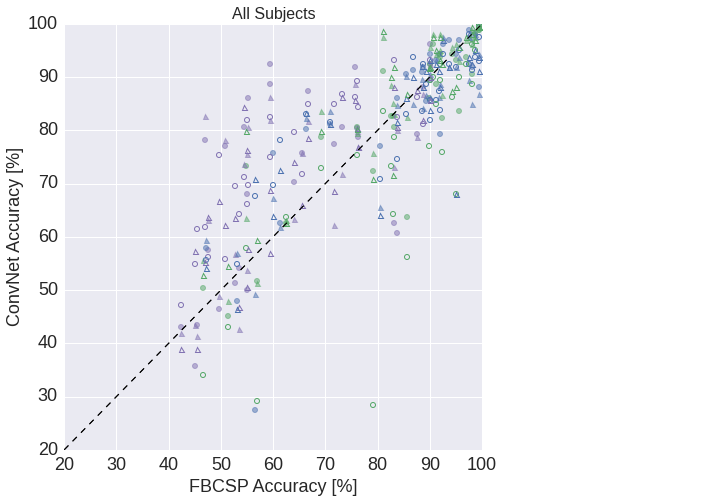

In [50]:
from numpy.random import RandomState

param_keys = ['freq', 'net',  'train_type', 'clean']
all_groups = all_df.groupby(param_keys)

all_test_net = []
all_test_csp = []
rng = RandomState(394834)
plt.figure(figsize=(7,7))
for wanted_train_type in ('cnt', 'epo'):
    for wanted_net in ('deep5', 'shallow'):
        
        offset = 0
        for name, group in all_groups:
            assert len(group['freq'].unique()) == 1
            freq = group['freq'].iloc[0]
            assert len(group['net'].unique()) == 1
            net = group['net'].iloc[0]
            assert len(group['clean'].unique()) == 1
            clean = group['clean'].iloc[0]
            assert len(group['train_type'].unique()) == 1
            train_type = group['train_type'].iloc[0]
            if clean == True: continue
            if net == 'csp': continue
            if net != wanted_net: continue
            if train_type != wanted_train_type: continue
            csp = all_df[(all_df.net == 'csp') & (all_df.freq == freq) &
                        (all_df.clean == clean)]
            assert (len(csp) == 29 and not clean) or (len(csp) == 23 and clean)
            df_merged = group.merge(csp, on='dataset_filename', suffixes=('_net','_csp'))

            test_acc_net = np.array(df_merged['test_net'])
            test_acc_csp = np.array(df_merged['test_csp'])
            all_test_net.append(test_acc_net)
            all_test_csp.append(test_acc_csp)
            diffs = test_acc_net - test_acc_csp
            if net == 'deep5':
                marker = 'o'
            else:
                assert net == 'shallow'
                marker = '^'
            if '>0' == freq:
                color = seaborn.color_palette()[0]
            elif '>4' == freq:
                color = seaborn.color_palette()[1]
            else:
                assert freq == '0-4'
                color = seaborn.color_palette()[3]
            markerfacecolor = 'None'
            if 'cnt' == train_type:
                markerfacecolor = color

            plt.plot(
                    test_acc_csp, test_acc_net, color=color, marker=marker, alpha=0.5, linestyle='None',
                    markersize=5,markeredgecolor=color, markerfacecolor=markerfacecolor, 
                     markeredgewidth=1)
            #plt.xlabel('FBCSP Accuracy [%]')


    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[12:30], (
                               'Deep 0-4 Hz (cropped)', 
                               'Deep 0-4 Hz (trial)',
                               'Shallow 0-4 Hz (cropped)',
                               'Shallow 0-4 Hz (trial)',
                               'Deep 0-125 Hz (cropped)', 
                               'Deep 0-125 Hz (trial)',
                               'Shallow 0-125 Hz (cropped)',
                               'Shallow 0-125 Hz (trial)',
                               'Deep 4-125 Hz (cropped)', 
                               'Deep 4-125 Hz (trial)',
                               'Shallow 4-125 Hz (cropped)',
                               'Shallow 4-125 Hz (trial)',),
              bbox_to_anchor=(1.55,1),fontsize=14)

    plt.tight_layout()
    plt.xlabel('FBCSP Accuracy [%]', fontsize=18)

    plt.ylabel('ConvNet Accuracy [%]', fontsize=18)

    # We change the fontsize of minor ticks label 
    plt.gca().tick_params(axis='both', which='major', labelsize=18)
    plt.title('All Subjects', fontsize=16)
    plt.plot([20,100], [20,100], color='black', label='', linestyle='--', lw=1)

### add combined set comparison

In [51]:

param_keys = ['freq', 'net',  'train_type', 'clean']
all_groups = all_df.groupby(param_keys)

for name, group in all_groups:
    assert len(group['freq'].unique()) == 1
    freq = group['freq'].iloc[0]
    assert len(group['net'].unique()) == 1
    net = group['net'].iloc[0]
    assert len(group['clean'].unique()) == 1
    clean = group['clean'].iloc[0]
    assert len(group['train_type'].unique()) == 1
    train_type = group['train_type'].iloc[0]
    if net == 'csp': continue
    log.info("{:s} {:s} {:s} (clean: {:s})".format(freq,net, train_type, str(clean)))
    csp = all_df[(all_df.net == 'csp') & (all_df.freq == freq) &
                (all_df.clean == clean)]
    assert (len(csp) == 29 and not clean) or (len(csp) == 23 and clean)
    df_compare = compare_csp_net(group, csp, net, freq, 'combined', with_csp_acc=True, with_std=True,
                                with_std_error=True)
    df_compare['clean'] = clean
    df_compare['train_type'] = train_type
    all_compared = all_compared.append(df_compare)

INFO:root:0-4 deep5 cnt (clean: False)
INFO:root:0-4 deep5 cnt (clean: True)
INFO:root:0-4 deep5 epo (clean: False)
INFO:root:0-4 deep5 epo (clean: True)
INFO:root:0-4 shallow cnt (clean: False)
INFO:root:0-4 shallow cnt (clean: True)
INFO:root:0-4 shallow epo (clean: False)
INFO:root:0-4 shallow epo (clean: True)
INFO:root:>0 deep5 cnt (clean: False)
INFO:root:>0 deep5 cnt (clean: True)
INFO:root:>0 deep5 epo (clean: False)
INFO:root:>0 deep5 epo (clean: True)
INFO:root:>0 shallow cnt (clean: False)
INFO:root:>0 shallow cnt (clean: True)
INFO:root:>0 shallow epo (clean: False)
INFO:root:>0 shallow epo (clean: True)
INFO:root:>4 deep5 cnt (clean: False)
INFO:root:>4 deep5 cnt (clean: True)
INFO:root:>4 deep5 epo (clean: False)
INFO:root:>4 deep5 epo (clean: True)
INFO:root:>4 shallow cnt (clean: False)
INFO:root:>4 shallow cnt (clean: True)
INFO:root:>4 shallow epo (clean: False)
INFO:root:>4 shallow epo (clean: True)


In [104]:
all_compared[(all_compared.dataset == 'combined') & 
             (all_compared.clean ==False) & (all_compared.freq != '0-4')].sort_values(by='rand')

,name,freq,dataset,test_csp,test_net,diff,std,stderr,rand,wilc,sign,time_net,clean,train_type
0,deep5,>4,combined,83.6,75.0,-8.6,12.0,2.2,0.000035,0.000098,0.008130,00:19:57,False,epo
0,shallow,>4,combined,83.6,85.9,2.2,5.3,1.0,0.031940,0.056226,0.024120,00:32:34,False,cnt
0,shallow,>4,combined,83.6,86.2,2.6,7.1,1.3,0.063118,0.029064,0.000546,00:16:56,False,epo
0,deep5,>4,combined,83.6,82.7,-1.0,7.3,1.3,0.494102,0.304193,0.458258,00:46:05,False,cnt
0,shallow,>0,combined,84.2,83.4,-0.8,7.1,1.3,0.565690,0.392654,0.711071,00:27:37,False,cnt
0,deep5,>0,combined,84.2,84.5,0.3,8.4,1.6,0.841533,0.416920,0.264931,00:48:49,False,cnt
0,shallow,>0,combined,84.2,83.8,-0.3,8.5,1.6,0.842442,0.932128,1.000000,00:13:53,False,epo
0,deep5,>0,combined,84.2,84.2,0.0,7.4,1.4,0.975386,0.701329,0.264931,00:18:24,False,epo


In [105]:
all_compared[(all_compared.dataset == 'combined') & 
             (all_compared.clean ==True) & (all_compared.freq != '0-4')].sort_values(by='rand')

,name,freq,dataset,test_csp,test_net,diff,std,stderr,rand,wilc,sign,time_net,clean,train_type
0,deep5,>4,combined,81.9,76.0,-5.9,8.7,1.8,0.001698,0.003874,0.093140,00:18:44,True,epo
0,shallow,>4,combined,81.9,85.2,3.4,5.2,1.1,0.003603,0.002136,0.000488,00:26:43,True,cnt
0,shallow,>4,combined,81.9,85.3,3.5,7.5,1.6,0.037113,0.023325,0.002599,00:12:34,True,epo
0,deep5,>0,combined,82.1,84.0,1.9,8.3,1.7,0.315499,0.023325,0.034690,00:42:22,True,cnt
0,deep5,>4,combined,81.9,83.1,1.2,5.5,1.1,0.319158,0.893212,1.000000,00:39:43,True,cnt
0,deep5,>0,combined,82.1,83.6,1.5,7.5,1.6,0.367605,0.643390,1.000000,00:17:08,True,epo
0,shallow,>0,combined,82.1,83.2,1.1,6.2,1.3,0.416855,0.709014,0.677639,00:22:15,True,cnt
0,shallow,>0,combined,82.1,83.1,1.1,8.6,1.8,0.587216,0.393073,0.404873,00:12:12,True,epo


In [53]:
all_compared[(all_compared.train_type == 'cnt') &
            (all_compared.dataset == 'combined') &
            (all_compared.freq != '0-4') &
            (all_compared.clean == False)].sort_values(by='name')

,name,freq,dataset,test_csp,test_net,diff,std,stderr,rand,wilc,sign,time_net,clean,train_type
0,deep5,>0,combined,84.2,84.5,0.3,8.4,1.6,0.841533,0.416920,0.264931,00:48:49,False,cnt
0,deep5,>4,combined,83.6,82.7,-1.0,7.3,1.3,0.494102,0.304193,0.458258,00:46:05,False,cnt
0,shallow,>0,combined,84.2,83.4,-0.8,7.1,1.3,0.565690,0.392654,0.711071,00:27:37,False,cnt
0,shallow,>4,combined,83.6,85.9,2.2,5.3,1.0,0.031940,0.056226,0.024120,00:32:34,False,cnt


In [54]:
all_compared[(all_compared.train_type == 'cnt') &
            (all_compared.dataset == 'combined') &
            (all_compared.freq != '0-4') &
            (all_compared.clean == True)].sort_values(by='name')

,name,freq,dataset,test_csp,test_net,diff,std,stderr,rand,wilc,sign,time_net,clean,train_type
0,deep5,>0,combined,82.1,84.0,1.9,8.3,1.7,0.315499,0.023325,0.034690,00:42:22,True,cnt
0,deep5,>4,combined,81.9,83.1,1.2,5.5,1.1,0.319158,0.893212,1.000000,00:39:43,True,cnt
0,shallow,>0,combined,82.1,83.2,1.1,6.2,1.3,0.416855,0.709014,0.677639,00:22:15,True,cnt
0,shallow,>4,combined,81.9,85.2,3.4,5.2,1.1,0.003603,0.002136,0.000488,00:26:43,True,cnt


In [107]:
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

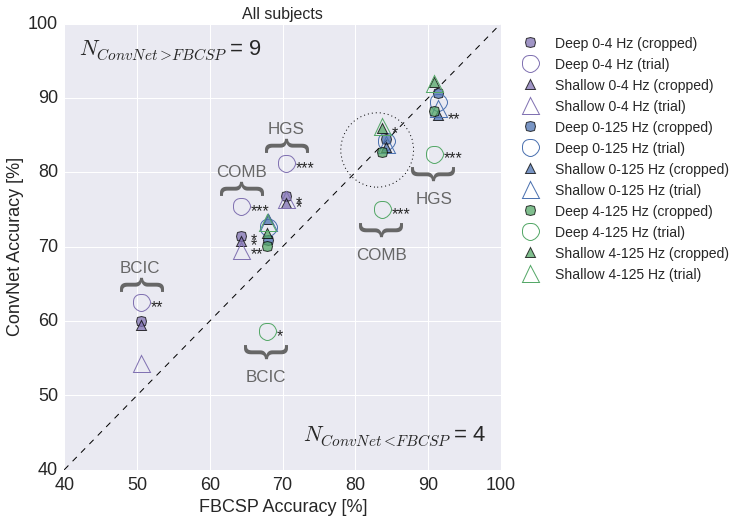

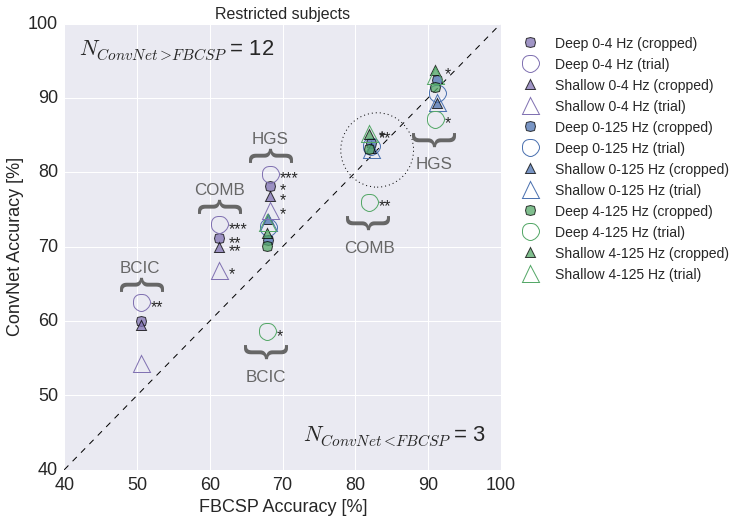

In [279]:
%config InlineBackend.figure_format = 'png' 

for clean in (False, True):
    fig = plt.figure(figsize=(7,7))

    plt.plot([40,100], [40,100], color='black', label='', linestyle='--', lw=1)

    all_labels = []
    sig_count_strong = []
    sig_count_weak = []
    for dataset in ('bcic', 'ours', 'combined'):
        for freq in ('0-4', '>0', '>4'):
            for net in ('deep5', 'shallow'):
                for train_type in ('cnt', 'epo',):
                    this_row = all_compared[(all_compared.dataset == dataset) &
                                           (all_compared.freq == freq) &
                                           (all_compared.train_type == train_type) &
                                           (all_compared.name == net) &
                                            (all_compared.clean == clean)]
                    assert len(this_row) == 1
                    this_row = this_row.iloc[0]
                    if net == 'deep5':
                        marker = 'o'
                    else:
                        assert net == 'shallow'
                        marker = '^'
                    if '>0' == freq:
                        color = seaborn.color_palette()[0]
                    elif '>4' == freq:
                        color = seaborn.color_palette()[1]
                    else:
                        assert freq == '0-4'
                        color = seaborn.color_palette()[3]
                    """if dataset == 'ours':
                        hsv = rgb_to_hsv(np.array([[color]]))
                        hsv[0,0,1:] *= 1.1
                        color = tuple(hsv_to_rgb(hsv)[0,0])
                    elif dataset == 'bcic':
                        hsv = rgb_to_hsv(np.array([[color]]))
                        hsv[0,0,1:] *= 0.85
                        color = tuple(hsv_to_rgb(hsv)[0,0])
                    else:
                        hsv = rgb_to_hsv(np.array([[color]]))
                        hsv[0,0,1:] *= 1.3
                        assert np.all(np.logical_or(hsv <= 1, hsv >= 0.))
                        color = tuple(hsv_to_rgb(hsv)[0,0])
                    assert np.all(np.logical_or(color <= 1, color >= 0.))"""
                    
                    markerfacecolor = 'None'
                    markersize=10
                    if train_type == 'epo':
                        markersize=17

                    markerfacecolor = 'None'
                    markeredgecolor = color
                    if 'cnt' == train_type:
                        markerfacecolor = color + (0.75,) # some alpha
                        markeredgecolor = 'black'
                        
                    test_csp = this_row['test_csp']
                    test_net = this_row['test_net']
                    

                    plt.plot(test_csp, test_net, color=color, 
                             marker=marker, linestyle='None', markersize=markersize, label='dummy',
                            markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor,
                            markeredgewidth=1)

                    # add significance star
                    if this_row['rand'] < 0.05:
                        if this_row['rand'] < 0.001:
                            signicance_str = '***'
                            sig_count_strong.append(int(np.sign(test_net - test_csp)))
                        elif this_row['rand'] < 0.01:
                            signicance_str = '**'
                            sig_count_strong.append(int(np.sign(test_net - test_csp)))
                         
                        else:
                            signicance_str = '*'
                            sig_count_weak.append(int(np.sign(test_net - test_csp)))
                        plt.annotate(
                            signicance_str, xy = (test_csp, test_net), xytext = (10, -4), fontsize=16,
                            textcoords = 'offset points', ha = 'left', va = 'center',)
                        
                    # add annotation
                    if train_type == 'epo' and net == 'deep5':
                        text_color = (0.4,0.4,0.4)
                        dataset_str = dataset.upper()[:4].replace('OURS', 'HGS')
                        if freq == '>4':
                            plt.annotate(dataset_str, xy=(test_csp, test_net),
                                         textcoords = 'offset points',
                                        xytext=(0,-50), ha='center', fontsize=17,
                                        color=text_color)
                            plt.annotate("{", xy=(test_csp, test_net),
                                         textcoords = 'offset points',
                                        xytext=(0,-47), ha='center', fontsize=47, rotation=90,
                                        color=text_color)
                        elif freq == '0-4':
                            plt.annotate(dataset_str, xy=(test_csp, test_net),
                                         textcoords = 'offset points',
                                        xytext=(0,30), ha='center', fontsize=17,
                                        color=text_color)
                            plt.annotate("{", xy=(test_csp, test_net),
                                         textcoords = 'offset points',
                                         va='top',
                                        xytext=(0,27), ha='center', fontsize=47, rotation=-90,
                                        color=text_color)
                            



    plt.xlabel('FBCSP Accuracy [%]', fontsize=18)

    plt.ylabel('ConvNet Accuracy [%]', fontsize=18)

    circle = plt.Circle((83,83), 5, facecolor='None', linestyle='dotted', linewidth=1)
    plt.gca().add_artist(circle)


    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[12:30], (
                               'Deep 0-4 Hz (cropped)', 
                               'Deep 0-4 Hz (trial)',
                               'Shallow 0-4 Hz (cropped)',
                               'Shallow 0-4 Hz (trial)',
                               'Deep 0-125 Hz (cropped)', 
                               'Deep 0-125 Hz (trial)',
                               'Shallow 0-125 Hz (cropped)',
                               'Shallow 0-125 Hz (trial)',
                               'Deep 4-125 Hz (cropped)', 
                               'Deep 4-125 Hz (trial)',
                               'Shallow 4-125 Hz (cropped)',
                               'Shallow 4-125 Hz (trial)',),
              bbox_to_anchor=(1.55,1),fontsize=14)

    plt.tight_layout()
    plt.annotate(u"$N_{{ConvNet>FBCSP}}$ = {:d}".format(np.sum(np.array(sig_count_strong) == 1)
                                                + np.sum(np.array(sig_count_weak) == 1)),xy=(42,96),
                fontsize=22)
    plt.annotate(u"$N_{{ConvNet<FBCSP}}$ = {:d}".format(np.sum(np.array(sig_count_strong) == -1)
                                                + np.sum(np.array(sig_count_weak) == -1)),xy=(98,44),
                fontsize=22, ha='right')


    # We change the fontsize of minor ticks label 
    plt.gca().tick_params(axis='both', which='major', labelsize=18)
    clean_str = 'Restricted subjects' if clean else 'All subjects'
    plt.title('{:s}'.format(clean_str), fontsize=16)

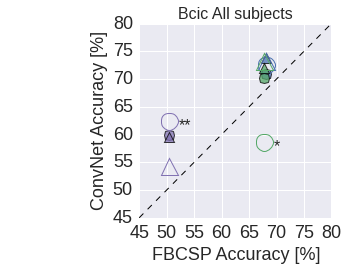

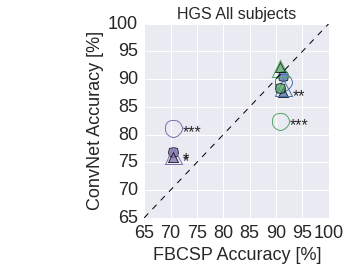

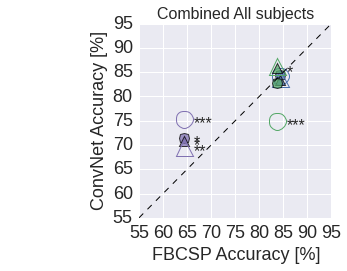

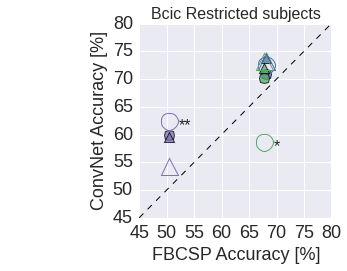

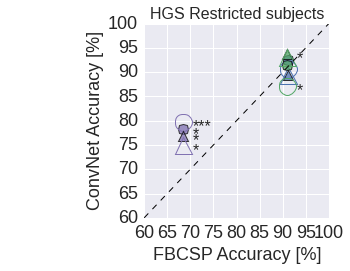

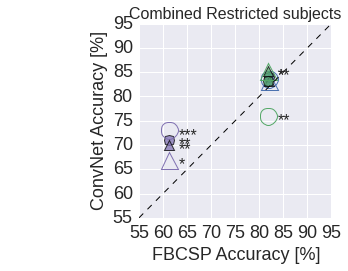

In [330]:
%config InlineBackend.figure_format = 'png' 

for clean in (False, True):
    for dataset in ('bcic', 'ours', 'combined'):
        fig = plt.figure(figsize=(3.5,3.5))


        all_labels = []
        sig_count_strong = []
        sig_count_weak = []
        for freq in ('0-4', '>0', '>4'):
            for net in ('deep5', 'shallow'):
                for train_type in ('cnt', 'epo',):
                    this_row = all_compared[(all_compared.dataset == dataset) &
                                           (all_compared.freq == freq) &
                                           (all_compared.train_type == train_type) &
                                           (all_compared.name == net) &
                                            (all_compared.clean == clean)]
                    assert len(this_row) == 1
                    this_row = this_row.iloc[0]
                    if net == 'deep5':
                        marker = 'o'
                    else:
                        assert net == 'shallow'
                        marker = '^'
                    if '>0' == freq:
                        color = seaborn.color_palette()[0]
                    elif '>4' == freq:
                        color = seaborn.color_palette()[1]
                    else:
                        assert freq == '0-4'
                        color = seaborn.color_palette()[3]
                    """if dataset == 'ours':
                        hsv = rgb_to_hsv(np.array([[color]]))
                        hsv[0,0,1:] *= 1.1
                        color = tuple(hsv_to_rgb(hsv)[0,0])
                    elif dataset == 'bcic':
                        hsv = rgb_to_hsv(np.array([[color]]))
                        hsv[0,0,1:] *= 0.85
                        color = tuple(hsv_to_rgb(hsv)[0,0])
                    else:
                        hsv = rgb_to_hsv(np.array([[color]]))
                        hsv[0,0,1:] *= 1.3
                        assert np.all(np.logical_or(hsv <= 1, hsv >= 0.))
                        color = tuple(hsv_to_rgb(hsv)[0,0])
                    assert np.all(np.logical_or(color <= 1, color >= 0.))"""
                    
                    markerfacecolor = 'None'
                    markersize=10
                    if train_type == 'epo':
                        markersize=17

                    markerfacecolor = 'None'
                    markeredgecolor = color
                    if 'cnt' == train_type:
                        markerfacecolor = color + (0.75,) # some alpha
                        markeredgecolor = 'black'
                        
                    test_csp = this_row['test_csp']
                    test_net = this_row['test_net']
                    

                    plt.plot(test_csp, test_net, color=color, 
                             marker=marker, linestyle='None', markersize=markersize, label='dummy',
                            markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor,
                            markeredgewidth=1)

                    # add significance star
                    if this_row['rand'] < 0.05:
                        if this_row['rand'] < 0.001:
                            signicance_str = '***'
                            sig_count_strong.append(int(np.sign(test_net - test_csp)))
                        elif this_row['rand'] < 0.01:
                            signicance_str = '**'
                            sig_count_strong.append(int(np.sign(test_net - test_csp)))
                         
                        else:
                            signicance_str = '*'
                            sig_count_weak.append(int(np.sign(test_net - test_csp)))
                        plt.annotate(
                            signicance_str, xy = (test_csp, test_net), xytext = (10, -4), fontsize=16,
                            textcoords = 'offset points', ha = 'left', va = 'center',)
                        
        
        min_x_y = min(plt.xlim()[0], plt.ylim()[0])
        max_x_y = max(plt.xlim()[1], plt.ylim()[1])
        plt.plot([min_x_y-5,max_x_y+5], [min_x_y-5,max_x_y+5], color='black', label='', linestyle='--', lw=1)


        plt.xlabel('FBCSP Accuracy [%]', fontsize=18)

        plt.ylabel('ConvNet Accuracy [%]', fontsize=18)
        """
        circle = plt.Circle((83,83), 5, facecolor='None', linestyle='dotted', linewidth=1)
        plt.gca().add_artist(circle)


        ax = plt.gca()"""
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[12:30], (
                                   'Deep 0-4 Hz (cropped)', 
                                   'Deep 0-4 Hz (trial)',
                                   'Shallow 0-4 Hz (cropped)',
                                   'Shallow 0-4 Hz (trial)',
                                   'Deep 0-125 Hz (cropped)', 
                                   'Deep 0-125 Hz (trial)',
                                   'Shallow 0-125 Hz (cropped)',
                                   'Shallow 0-125 Hz (trial)',
                                   'Deep 4-125 Hz (cropped)', 
                                   'Deep 4-125 Hz (trial)',
                                   'Shallow 4-125 Hz (cropped)',
                                   'Shallow 4-125 Hz (trial)',),
                  bbox_to_anchor=(1.55,1),fontsize=14)

        plt.tight_layout()
        plt.annotate(u"$N_{{ConvNet>FBCSP}}$ = {:d}".format(np.sum(np.array(sig_count_strong) == 1)
                                                    + np.sum(np.array(sig_count_weak) == 1)),xy=(42,96),
                    fontsize=22)
        plt.annotate(u"$N_{{ConvNet<FBCSP}}$ = {:d}".format(np.sum(np.array(sig_count_strong) == -1)
                                                    + np.sum(np.array(sig_count_weak) == -1)),xy=(98,44),
                    fontsize=22, ha='right')


        # We change the fontsize of minor ticks label 
        plt.gca().tick_params(axis='both', which='major', labelsize=18)
        clean_str = 'Restricted subjects' if clean else 'All subjects'
        title_str = dataset.capitalize().replace("Ours", "HGS") + " " + clean_str
        plt.title('{:s}'.format(title_str), fontsize=16)

## Without ELU/Bnorm/Drop

In [73]:
all_df_past = pd.DataFrame()
for dataset in ('bcic', 'ours'):
    for net in 'shallow', 'deep5':
        for training in 'epo', 'cnt':
            for band in ['>0', '>4', '0-4']:
                for clean in (True, False):
                    if dataset == 'bcic':
                        dfc = df_csp_bcic
                    else:
                        assert dataset == 'ours'
                        dfc = df_csp_ours
                    if dataset == 'bcic' and net == 'shallow' and training == 'cnt':
                        dfn = df_shallow_cnt_bcic
                    elif dataset == 'bcic' and net == 'shallow' and training == 'epo':
                        dfn = df_shallow_epo_bcic
                    elif dataset == 'bcic' and net == 'deep5' and training == 'cnt':
                        dfn = df_deep_cnt_bcic
                    elif dataset == 'bcic' and net == 'deep5' and training == 'epo':
                        dfn = df_deep_epo_bcic
                    elif dataset == 'ours' and net == 'shallow' and training == 'cnt':
                        dfn = df_shallow_cnt_ours
                    elif dataset == 'ours' and net == 'shallow' and training == 'epo':
                        dfn = df_shallow_epo_ours
                    elif dataset == 'ours' and net == 'deep5' and training == 'cnt':
                        dfn = df_deep_cnt_ours
                    elif dataset == 'ours' and net == 'deep5' and training == 'epo':
                        dfn = df_deep_epo_ours
                    else:
                        raise ValueError("Unknown combination")
                    if clean:
                        dfn = clean_datasets(dfn)
                        dfc = clean_datasets(dfc)
                    
                    dfn = past(dfn)
                        
                    if band == '>0':
                        this_dfn = above_0(dfn)
                        this_dfc = csp_above_0(dfc)
                    elif band == '>4':
                        this_dfn = above_4(dfn)
                        this_dfc = csp_above_4(dfc)
                    elif band == '0-4':
                        this_dfn = from_0_to_4(dfn)
                        this_dfc = csp_0_to_4(dfc)
                        
                    if training == 'cnt':
                        this_dfn = tied_loss(this_dfn)
                        
                    this_dfc = main_comp_csp(this_dfc)
                    
                    this_dfc = this_dfc[this_dfc.trial_start == 500]
                    if training == 'epo':
                        this_dfn = this_dfn[this_dfn.trial_start == -500]
                    else:
                        assert training == 'cnt'
                        this_dfn = this_dfn[this_dfn.trial_start == 1500]
                    
                    if dataset == 'bcic' and net == 'deep5' and (
                        training == 'epo' or (band == '>0' or band == '>4')):
                        this_dfn = this_dfn[this_dfn.layers == 'deep_5']
                    if training == 'epo':
                        this_dfn = this_dfn[this_dfn.max_increasing_epochs == 160]
                    else:
                        assert training == 'cnt'
                        this_dfn = this_dfn[this_dfn.max_increasing_epochs == 80]

                    if dataset == 'bcic':
                        assert len(this_dfc) == 9, "wrong length: {:d} ({:s})".format(
                            len(this_dfc), str((dataset, net, training, band, clean)))
                        assert len(this_dfn) == 9, "wrong length: {:d} ({:s})".format(
                            len(this_dfn), str((dataset, net, training, band, clean)))
                    elif dataset == 'ours' and clean:
                        assert len(this_dfc) == 14, "wrong length: {:d} ({:s})".format(
                            len(this_dfc), str((dataset, net, training, band, clean)))
                        assert len(this_dfn) == 14, "wrong length: {:d} ({:s})".format(
                            len(this_dfn), str((dataset, net, training, band, clean)))
                    elif dataset == 'ours' and (not clean):
                        assert len(this_dfc) == 20, "wrong length: {:d} ({:s})".format(
                            len(this_dfc), str((dataset, net, training, band, clean)))
                        assert len(this_dfn) == 20, "wrong length: {:d} ({:s})".format(
                            len(this_dfn), str((dataset, net, training, band, clean)))
                    else:
                        raise ValueError("Unknown combination")

                
                    this_dfn = remove_columns_with_same_value(this_dfn)
                    this_dfn['clean'] = clean
                    this_dfn['net'] = net
                    this_dfn['train_type'] = training
                    this_dfn['freq'] = band
                    this_dfn['dataset'] = dataset

                    all_df_past = all_df_past.append(this_dfn)
                    # no need to add csp... comparison csp stays same

In [74]:
assert len(all_df_past) == 12 * 29 +  12* 23 # no csp

In [75]:
all_compared_past = pd.DataFrame()
param_keys = ['dataset', 'freq', 'net',  'train_type', 'clean']
all_groups = all_df_past.groupby(param_keys)

for name, group in all_groups:
    assert len(group['freq'].unique()) == 1
    freq = group['freq'].iloc[0]
    assert len(group['dataset'].unique()) == 1
    dataset = group['dataset'].iloc[0]
    assert len(group['net'].unique()) == 1
    net = group['net'].iloc[0]
    assert len(group['clean'].unique()) == 1
    clean = group['clean'].iloc[0]
    assert len(group['train_type'].unique()) == 1
    train_type = group['train_type'].iloc[0]
    if net == 'csp': continue
    log.info("{:s} {:s} {:s} {:s} (clean: {:s})".format(dataset,
                                                        freq,net, train_type, str(clean)))
    csp = all_df[(all_df.net == 'csp') & (all_df.freq == freq) &
                (all_df.dataset == dataset) &
                (all_df.clean == clean)]
    df_compare = compare_csp_net(group, csp, net, freq, dataset, with_csp_acc=True, with_std=True,
                                with_std_error=True)   
    df_compare['clean'] = clean
    df_compare['train_type'] = train_type
    all_compared_past = all_compared_past.append(df_compare)


param_keys = ['freq', 'net',  'train_type', 'clean']
all_groups = all_df_past.groupby(param_keys)

for name, group in all_groups:
    assert len(group['freq'].unique()) == 1
    freq = group['freq'].iloc[0]
    assert len(group['net'].unique()) == 1
    net = group['net'].iloc[0]
    assert len(group['clean'].unique()) == 1
    clean = group['clean'].iloc[0]
    assert len(group['train_type'].unique()) == 1
    train_type = group['train_type'].iloc[0]
    if net == 'csp': continue
    log.info("combined: {:s} {:s} {:s} (clean: {:s})".format(freq,net, train_type, str(clean)))
    csp = all_df[(all_df.net == 'csp') & (all_df.freq == freq) &
                (all_df.clean == clean)]
    assert (len(csp) == 29 and not clean) or (len(csp) == 23 and clean)
    df_compare = compare_csp_net(group, csp, net, freq, 'combined', with_csp_acc=True, with_std=True,
                                with_std_error=True)
    df_compare['clean'] = clean
    df_compare['train_type'] = train_type
    all_compared_past = all_compared_past.append(df_compare)

INFO:root:bcic 0-4 deep5 cnt (clean: False)
INFO:root:bcic 0-4 deep5 cnt (clean: True)
INFO:root:bcic 0-4 deep5 epo (clean: False)
INFO:root:bcic 0-4 deep5 epo (clean: True)
INFO:root:bcic 0-4 shallow cnt (clean: False)
INFO:root:bcic 0-4 shallow cnt (clean: True)
INFO:root:bcic 0-4 shallow epo (clean: False)
INFO:root:bcic 0-4 shallow epo (clean: True)
INFO:root:bcic >0 deep5 cnt (clean: False)
INFO:root:bcic >0 deep5 cnt (clean: True)
INFO:root:bcic >0 deep5 epo (clean: False)
INFO:root:bcic >0 deep5 epo (clean: True)
INFO:root:bcic >0 shallow cnt (clean: False)
INFO:root:bcic >0 shallow cnt (clean: True)
INFO:root:bcic >0 shallow epo (clean: False)
INFO:root:bcic >0 shallow epo (clean: True)
INFO:root:bcic >4 deep5 cnt (clean: False)
INFO:root:bcic >4 deep5 cnt (clean: True)
INFO:root:bcic >4 deep5 epo (clean: False)
INFO:root:bcic >4 deep5 epo (clean: True)
INFO:root:bcic >4 shallow cnt (clean: False)
INFO:root:bcic >4 shallow cnt (clean: True)
INFO:root:bcic >4 shallow epo (clean:

In [76]:
all_compared_past[(all_compared.name == 'deep5') & (all_compared.dataset == 'ours') 
                 ]

,name,freq,dataset,test_csp,test_net,diff,std,stderr,rand,wilc,sign,time_net,clean,train_type
0,deep5,0-4,ours,70.5,67.1,-3.4,9.1,2.0,0.114450,0.153646,0.263176,00:20:56,False,cnt
0,deep5,0-4,ours,68.3,64.8,-3.5,9.8,2.6,0.226929,0.295776,0.423950,00:20:19,True,cnt
0,deep5,0-4,ours,70.5,70.8,0.3,11.7,2.6,0.915165,0.812355,0.503445,00:08:27,False,epo
0,deep5,0-4,ours,68.3,68.5,0.2,12.7,3.4,0.969604,0.903198,0.790527,00:07:22,True,epo
0,deep5,>0,ours,91.4,80.0,-11.5,21.4,4.8,0.004128,0.001209,0.011818,00:26:52,False,cnt
0,deep5,>0,ours,91.2,83.6,-7.5,18.6,5.0,0.104004,0.035278,0.179565,00:26:17,True,cnt
0,deep5,>0,ours,91.4,77.6,-13.9,14.4,3.2,0.000029,0.000048,0.000040,00:08:23,False,epo
0,deep5,>0,ours,91.2,77.0,-14.1,17.1,4.6,0.001709,0.002319,0.001831,00:07:35,True,epo
0,deep5,>4,ours,90.8,68.9,-21.9,24.6,5.5,0.000195,0.000322,0.011818,00:35:40,False,cnt
0,deep5,>4,ours,90.9,74.4,-16.5,23.5,6.3,0.012451,0.020264,0.179565,00:34:37,True,cnt


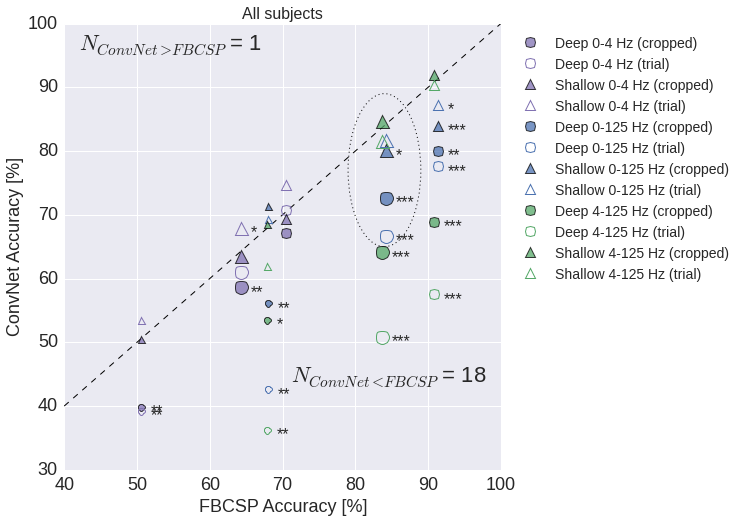

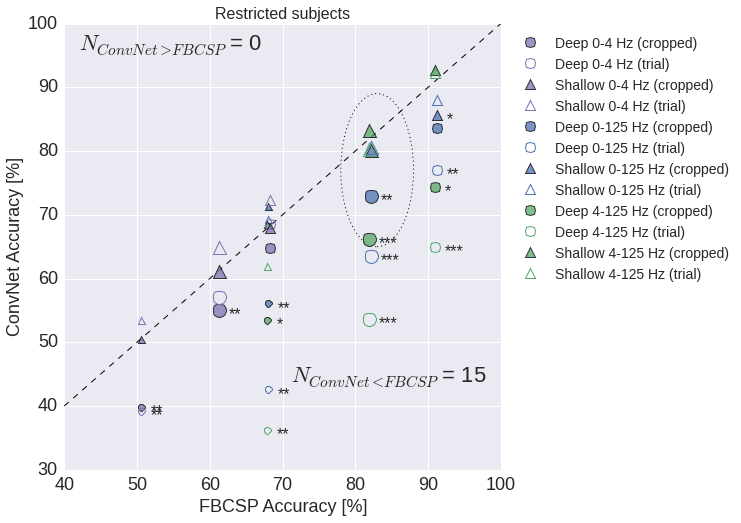

In [77]:
%config InlineBackend.figure_format = 'png' 

for clean in (False, True):
    fig = plt.figure(figsize=(7,7))

    plt.plot([40,100], [40,100], color='black', label='', linestyle='--', lw=1)

    all_labels = []
    sig_count_strong = []
    sig_count_weak = []
    for dataset in ('bcic', 'ours', 'combined'):
        for freq in ('0-4', '>0', '>4'):
            for net in ('deep5', 'shallow'):
                for train_type in ('cnt', 'epo'):
                    this_row = all_compared_past[(all_compared_past.dataset == dataset) &
                                           (all_compared_past.freq == freq) &
                                           (all_compared_past.train_type == train_type) &
                                           (all_compared_past.name == net) &
                                            (all_compared_past.clean == clean)]
                    assert len(this_row) == 1
                    this_row = this_row.iloc[0]
                    if net == 'deep5':
                        marker = 'o'
                    else:
                        assert net == 'shallow'
                        marker = '^'
                    if '>0' == freq:
                        color = seaborn.color_palette()[0]
                    elif '>4' == freq:
                        color = seaborn.color_palette()[1]
                    else:
                        assert freq == '0-4'
                        color = seaborn.color_palette()[3]
                    markerfacecolor = 'None'
                    if 'bcic' == dataset:
                        markersize=7
                    elif 'ours' == dataset:
                        markersize=10
                    elif 'combined' == dataset:
                        markersize=13 

                    markerfacecolor = 'None'
                    markeredgecolor = color
                    if 'cnt' == train_type:
                        markerfacecolor = color + (0.75,) # some alpha
                        markeredgecolor = 'black'
                        
                    test_csp = this_row['test_csp']
                    test_net = this_row['test_net']
                    

                    plt.plot(test_csp, test_net, color=color, 
                             marker=marker, linestyle='None', markersize=markersize, label='dummy',
                            markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor,
                            markeredgewidth=1)

                    # add significance star
                    if this_row['rand'] < 0.05:
                        if this_row['rand'] < 0.001:
                            signicance_str = '***'
                            sig_count_strong.append(int(np.sign(test_net - test_csp)))
                        elif this_row['rand'] < 0.01:
                            signicance_str = '**'
                            sig_count_strong.append(int(np.sign(test_net - test_csp)))
                         
                        else:
                            signicance_str = '*'
                            sig_count_weak.append(int(np.sign(test_net - test_csp)))
                        plt.annotate(
                            signicance_str, xy = (test_csp, test_net), xytext = (10, -4), fontsize=16,
                            textcoords = 'offset points', ha = 'left', va = 'center',)



    plt.xlabel('FBCSP Accuracy [%]', fontsize=18)

    plt.ylabel('ConvNet Accuracy [%]', fontsize=18)

   
    if clean:
        ellipse = matplotlib.patches.Ellipse((83,77), 10,24,
                                        facecolor='None', linestyle='dotted', linewidth=1)
    else:
        ellipse = matplotlib.patches.Ellipse((84,77), 10,24,
                                        facecolor='None', linestyle='dotted', linewidth=1)
        
    plt.gca().add_artist(ellipse)


    
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[12:30], (
                               'Deep 0-4 Hz (cropped)', 
                               'Deep 0-4 Hz (trial)',
                               'Shallow 0-4 Hz (cropped)',
                               'Shallow 0-4 Hz (trial)',
                               'Deep 0-125 Hz (cropped)', 
                               'Deep 0-125 Hz (trial)',
                               'Shallow 0-125 Hz (cropped)',
                               'Shallow 0-125 Hz (trial)',
                               'Deep 4-125 Hz (cropped)', 
                               'Deep 4-125 Hz (trial)',
                               'Shallow 4-125 Hz (cropped)',
                               'Shallow 4-125 Hz (trial)',),
              bbox_to_anchor=(1.55,1),fontsize=14)

    plt.tight_layout()
    plt.annotate(u"$N_{{ConvNet>FBCSP}}$ = {:d}".format(np.sum(np.array(sig_count_strong) == 1)
                                                + np.sum(np.array(sig_count_weak) == 1)),xy=(42,96),
                fontsize=22)
    plt.annotate(u"$N_{{ConvNet<FBCSP}}$ = {:d}".format(np.sum(np.array(sig_count_strong) == -1)
                                                + np.sum(np.array(sig_count_weak) == -1)),xy=(98,44),
                fontsize=22, ha='right')


    # We change the fontsize of minor ticks label 
    plt.gca().tick_params(axis='both', which='major', labelsize=18)
    clean_str = 'Restricted subjects' if clean else 'All subjects'
    plt.title('{:s}'.format(clean_str), fontsize=16)


In [78]:
all_df[(all_df.dataset == 'ours') & (all_df.test_filename.str.contains('MaVo')) &
      (all_df.freq == '>0') & (all_df.clean == False)]

,clean,dataset,dataset_filename,freq,net,test,test_filename,test_sample,time,train,train_sample,train_type,trial_start
597,False,ours,data/BBCI-without-last-runs/MaVoMoSc1S001R01_d...,>0,shallow,98.125,data/BBCI-only-last-runs/MaVoMoSc1S001R12_ds10...,NaN,00:19:08,100.000000,NaN,epo,-500
173,False,ours,data/BBCI-without-last-runs/MaVoMoSc1S001R01_d...,>0,csp,97.500,data/BBCI-only-last-runs/MaVoMoSc1S001R12_ds10...,NaN,00:10:46,99.545455,NaN,epo,500
489,False,ours,data/BBCI-without-last-runs/MaVoMoSc1S001R01_d...,>0,shallow,97.500,data/BBCI-only-last-runs/MaVoMoSc1S001R12_ds10...,94.771815,00:36:11,100.000000,99.103562,cnt,-500
542,False,ours,data/BBCI-without-last-runs/MaVoMoSc1S001R01_d...,>0,deep5,98.125,data/BBCI-only-last-runs/MaVoMoSc1S001R12_ds10...,NaN,00:36:23,100.000000,NaN,epo,-500
617,False,ours,data/BBCI-without-last-runs/MaVoMoSc1S001R01_d...,>0,deep5,98.750,data/BBCI-only-last-runs/MaVoMoSc1S001R12_ds10...,97.173800,01:09:39,100.000000,99.867266,cnt,-500


In [79]:
result = np.load('data/models/paper/ours/cnt/shallow/307.result.pkl')

result.monitor_channels['test_sample_misclass'][-3:]

[0.5435861450315411, 0.5319607616181492, 0.5375962150587419]

In [80]:

result.monitor_channels['test_misclass'][-3:]

[0.5, 0.46621621621621623, 0.46621621621621623]

### Trial vs Sample

In [242]:
clean_trial_sample = True
    
df_cnt = all_compared[(all_compared.train_type == 'cnt') &
                     (all_compared.clean == clean_trial_sample)]

df_cnt_epo = pd.DataFrame()
for i_row in xrange(len(df_cnt)):
    this_row = df_cnt.iloc[i_row,:]
    
    if this_row['dataset'] in ('bcic', 'ours'):
        this_cnt = all_df[(all_df.net == this_row['name']) & 
                         (all_df.freq == this_row['freq'])& 
                         (all_df.dataset == this_row['dataset']) &
                         (all_df.train_type == 'cnt') &
                         (all_df.clean == clean_trial_sample)]
    else:
        assert this_row['dataset'] == 'combined'
        this_cnt_1 = all_df[(all_df.net == this_row['name']) & 
                         (all_df.freq == this_row['freq'])& 
                         (all_df.dataset == 'bcic') &
                         (all_df.train_type == 'cnt') &
                         (all_df.clean == clean_trial_sample) &
                         (all_df.clean == clean_trial_sample)]
        this_cnt_2 = all_df[(all_df.net == this_row['name']) & 
                         (all_df.freq == this_row['freq'])& 
                         (all_df.dataset == 'ours') &
                         (all_df.train_type == 'cnt') &
                         (all_df.clean == clean_trial_sample)]
        this_cnt = pd.concat((this_cnt_1, this_cnt_2))

    if this_row['dataset'] in ('bcic', 'ours'):
        this_epo = all_df[(all_df.net == this_row['name']) & 
                         (all_df.freq == this_row['freq'])& 
                         (all_df.dataset == this_row['dataset']) &
                         (all_df.train_type == 'epo') &
                         (all_df.clean == clean_trial_sample)]
    else:
        assert this_row['dataset'] == 'combined'
        this_epo_1 = all_df[(all_df.net == this_row['name']) & 
                         (all_df.freq == this_row['freq']) & 
                         (all_df.dataset == 'bcic') &
                         (all_df.train_type == 'epo') &
                         (all_df.clean == clean_trial_sample)]
        this_epo_2 = all_df[(all_df.net == this_row['name']) & 
                         (all_df.freq == this_row['freq']) & 
                         (all_df.dataset == 'ours') &
                         (all_df.train_type == 'epo') &
                         (all_df.clean == clean_trial_sample)]
        this_epo = pd.concat((this_epo_1, this_epo_2))
    df_merged = this_epo.merge(this_cnt, on='dataset_filename', suffixes=('_epo','_cnt'))
    # this is only for latter scatterplot
    df_merged = df_merged.sort_values(by='dataset_filename')
    
    cnt_test = np.array(df_merged['test_cnt'])
    epo_test = np.array(df_merged['test_epo'])
        
    this_df = pd.DataFrame()
    this_df['dataset'] = [this_row['dataset']]
    this_df['net'] = [this_row['name'].replace('cnt ', '')]
    this_df['freq'] = [this_row['freq']]
    this_df['test'] = [np.mean(epo_test)]
    this_df['diff'] = [np.mean(cnt_test - epo_test)]
    this_df['std'] = [np.std(cnt_test - epo_test)]
    this_df['stderr'] = [np.std(cnt_test - epo_test) / np.sqrt(len(cnt_test))]
    this_df['test_epo_subjects'] = [epo_test]
    this_df['test_cnt_subjects'] = [cnt_test]
    log.info("{:s} {:s} {:s}".format(this_row['dataset'],
        this_row['freq'], this_row['name']))
    add_p_vals_to_df_row(this_df, cnt_test, epo_test)
    
    df_cnt_epo = pd.concat((df_cnt_epo, this_df))

INFO:root:bcic 0-4 deep5
INFO:root:bcic 0-4 shallow
INFO:root:bcic >0 deep5
INFO:root:bcic >0 shallow
INFO:root:bcic >4 deep5
INFO:root:bcic >4 shallow
INFO:root:ours 0-4 deep5
INFO:root:ours 0-4 shallow
INFO:root:ours >0 deep5
INFO:root:ours >0 shallow
INFO:root:ours >4 deep5
INFO:root:ours >4 shallow
INFO:root:combined 0-4 deep5
INFO:root:combined 0-4 shallow
INFO:root:combined >0 deep5
INFO:root:combined >0 shallow
INFO:root:combined >4 deep5
INFO:root:combined >4 shallow


In [235]:
this_df['test_epo'] = [epo_test]

In [238]:
test_epo = this_df['test_epo'][0]

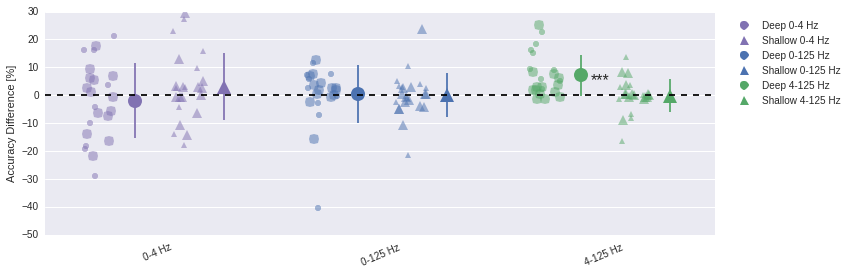

In [288]:
from matplotlib.lines import Line2D
rng = RandomState(39884934)
plt.figure(figsize=(12,4))
rands = rng.randn(23) #rng.randn(len(diffs))
offset = 0
for freq in ('0-4', '>0', '>4'):
    for net in ('deep5', 'shallow'):
        this_row = df_cnt_epo[(df_cnt_epo.dataset == 'combined') &
                             (df_cnt_epo.freq == freq) &
                             (df_cnt_epo.net == net)]
        label = 'dummy'
        if net == 'deep5':
            marker = 'o'
        else:
            assert net == 'shallow'
            marker = '^'
        if '0-4' == freq:
            color = seaborn.color_palette()[3]
        elif '>0' == freq:
            color = seaborn.color_palette()[0]
        elif '>4' == freq:
            color = seaborn.color_palette()[1]
        


        cnt_test = this_row['test_cnt_subjects'][0]
        epo_test = this_row['test_epo_subjects'][0]
        diffs = cnt_test - epo_test
        # try plotting ours and bcic with different marker sizes, quite hacky(first 14 shouldbe ours)
        assert clean_trial_sample
        plt.plot(rands[:14] * 0.05 + offset - 0.2,
                diffs[:14], color=color, marker=marker, alpha=0.5, linestyle='None',
                markersize=10) #markersize 8
        plt.plot(rands[14:] * 0.05 + offset - 0.2,
                diffs[14:], color=color, marker=marker, alpha=0.5, linestyle='None',
                markersize=6)
        plt.errorbar(offset, this_row['diff'][0], color=color,
                     yerr=this_row['std'][0], marker=marker,
                    markersize=14, label=label)

        if this_row['rand'][0] < 0.05:
            if this_row['rand'][0] < 0.001:
                signicance_str = '***'
            elif this_row['rand'][0] < 0.01:
                signicance_str = '**'
            else:
                signicance_str = '*'
            plt.annotate(
                signicance_str, xy=(offset, this_row['diff'][0]), xytext=(10, -4), fontsize=16,
                    textcoords='offset points', ha = 'left', va = 'center',)

        offset += 0.5
    offset += 0.25
plt.axhline(y=0, color='black', linestyle='dashed')
plt.xticks(np.arange(0.125,3,1.25), ('0-4 Hz', '0-125 Hz', '4-125 Hz'), rotation=23)
plt.xlim(-0.5,3.25)
plt.grid('off', axis='x')
plt.ylabel('Accuracy Difference [%]')
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
# recreate  with empty line, only marker
handles = [Line2D([0], [0], color=h[0].get_color(), marker=h[0].get_marker(),
    markersize=9, linewidth=0) for h in handles]
ax.legend(handles, ('Deep 0-4 Hz', 'Shallow 0-4 Hz',
                          'Deep 0-125 Hz', 'Shallow 0-125 Hz',
                          'Deep 4-125 Hz', 'Shallow 4-125 Hz'), 
          bbox_to_anchor=(1.2,1))
None

### Modification Experiments

In [245]:
clean_mod_compare = True
df_mod = pd.DataFrame()
shallow_variants = [
                   ('No Dropout', lambda df: no_drop(yes_bnorm(df))),
                   ('No Batch Norm', lambda df: yes_drop(no_bnorm(df))),
                   ('No Dropout No Batch Norm', lambda df: no_drop(no_bnorm(df))),
                   ('No Split 1st Layer', no_split_first_layer),
                   ('No Tied Loss', no_tied_loss),
                   ('Sqrt instead of log', square_mean_sqrt),
                   ('Elu Max', elu_max_shallow),
                   ('Elu Mean', elu_mean_shallow),]

deep_variants = [
                   ('No Dropout', lambda df: tied_loss(no_drop(yes_bnorm(df)))),
                   ('No Batch Norm', lambda df: tied_loss(split_first_layer(yes_drop(no_bnorm(df))))),
                   ('No Dropout No Batch Norm', lambda df: tied_loss(
                        single_time_convs(elu_nonlins(no_drop(no_bnorm(df)))))),
                   ('No Split 1st Layer', no_split_first_layer),
                   ('No Tied Loss', lambda df: no_tied_loss(
                        single_time_convs(yes_drop(yes_bnorm(elu_nonlins(df)))))),
                   ('ReLU', lambda df: relu_nonlins(yes_bnorm(df))),
                   ('Log(Mean(Square)) first', square_mean_first),
                   ('Log(Max(Square)) first', square_max_first),
                   ('6x1+6x1 convs', double_time_convs),]

for dataset in 'bcic', 'ours', 'combined':
    for net in 'shallow', 'deep5':
        if net == 'shallow':
            variants = shallow_variants
        else:
            assert net == 'deep5'
            variants = deep_variants
        if dataset == 'bcic' and net == 'shallow':
            df_compare = df_shallow_cnt_bcic
        elif dataset == 'bcic' and net == 'deep5':
            df_compare = df_deep_cnt_bcic
        elif dataset == 'ours' and net == 'shallow':
            df_compare = df_shallow_cnt_ours
        elif dataset == 'ours' and net == 'deep5':
            df_compare = df_deep_cnt_ours
        elif dataset == 'combined' and net == 'shallow':
            df_compare = (df_shallow_cnt_bcic, df_shallow_cnt_ours)
        elif dataset == 'combined' and net == 'deep5':
            df_compare = (df_deep_cnt_bcic, df_deep_cnt_ours)
        else:
            raise ValueError("unknown combination")
            
        if clean_mod_compare:
            if dataset != 'combined':
                df_compare = clean_datasets(df_compare)
            else:
                assert dataset == 'combined'
                df_compare = [clean_datasets(df_set) for df_set in df_compare]
        if dataset != 'combined':
            df_compare = df_compare[df_compare.max_increasing_epochs == 80]
        else:
            assert dataset == 'combined'
            df_compare = [df_set[df_set.max_increasing_epochs == 80] for df_set in df_compare]
            
        for freq in '>0', '>4':
            if dataset in ('bcic', 'ours'):
                df_baseline = all_df[(all_df.net == net)&
                                    (all_df.freq == freq) &
                                    (all_df.dataset == dataset) &
                                    (all_df.train_type == 'cnt') &
                                    (all_df.clean == clean_mod_compare)]
            else:
                df_baseline =  all_df[(all_df.net == net)&
                                    (all_df.freq == freq) &
                                    (all_df.train_type == 'cnt') &
                                    (all_df.clean == clean_mod_compare)]
                
            for var_name, var_func in variants:
                if freq == '>0' and dataset in ('bcic', 'ours'):
                    df_var = var_func(above_0(df_compare))
                elif dataset in ('bcic', 'ours'):
                    assert freq == '>4'
                    df_var = var_func(above_4(df_compare))
                elif freq == '>0' and dataset == 'combined':
                    df_var_1 = var_func(above_0(df_compare[0]))
                    df_var_2 = var_func(above_0(df_compare[1]))
                    df_var = pd.concat((df_var_1, df_var_2))
                elif freq == '>4' and dataset == 'combined':
                    df_var_1 = var_func(above_4(df_compare[0]))
                    df_var_2 = var_func(above_4(df_compare[1]))
                    df_var = pd.concat((df_var_1, df_var_2))
                if var_name != 'No Tied Loss':
                    df_var = tied_loss(df_var)
                if dataset == 'bcic':
                    assert len(df_var) == 9
                elif dataset == 'ours':
                    assert len(df_var) == 20 or (len(df_var) == 14 and clean_mod_compare)
                else:
                    assert dataset == 'combined'
                    assert len(df_var) == 29 or (len(df_var) == 23 and clean_mod_compare)
                assert len(df_var) == len(df_baseline), (
                    "Expect length of variant {:d} to be same as length of baseline {:d}".format(
                    len(df_var), len(df_baseline)))
                df_merged = df_baseline.merge(df_var, on='dataset_filename', suffixes=('_base','_var'))
                # not really necessary to sort, just to make sure 
                df_merged = df_merged.sort_values(by='dataset_filename')
                test_baseline = np.array(df_merged.test_base)
                test_variant = np.array(df_merged.test_var)
                this_df_mod = pd.DataFrame()
                this_df_mod['dataset'] = [dataset]
                this_df_mod['net'] = [net]
                this_df_mod['freq'] = [freq]
                this_df_mod['variant'] = [var_name]
                this_df_mod['test'] = [np.mean(df_merged.test_var)]
                this_df_mod['diff'] = [np.mean(df_merged.test_var - df_merged.test_base)]
                this_df_mod['std'] = [np.std(df_merged.test_var - df_merged.test_base)]
                this_df_mod['stderr'] = [np.std(df_merged.test_var - df_merged.test_base) / 
                                         np.sqrt(len(df_merged))]
                this_df_mod['test_baseline_subjects'] = [test_baseline]
                this_df_mod['test_variant_subjects'] = [test_variant]
                
                add_p_vals_to_df_row(this_df_mod, test_variant, 
                                     test_baseline, n_diffs_for_large=2**17)
                df_mod = pd.concat((df_mod, this_df_mod))

In [246]:
common_variants = np.intersect1d(zip(*deep_variants)[0], zip(*shallow_variants)[0])

other_shallow_vars = np.setdiff1d(zip(*shallow_variants)[0], zip(*deep_variants)[0])[::-1]
other_deep_vars = np.setdiff1d(zip(*deep_variants)[0], zip(*shallow_variants)[0])[::-1]
all_variants = np.concatenate((common_variants, other_shallow_vars,other_deep_vars))

uncommon_variants = np.concatenate((other_shallow_vars, other_deep_vars))

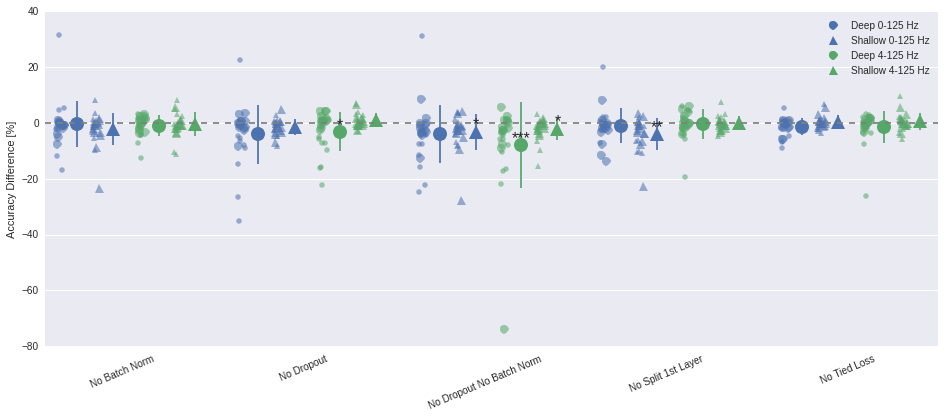

In [317]:
plt.figure(figsize=(16,6))
offset = 0
for i_var, var_name in enumerate(common_variants):
    for freq in [">0", ">4"]:
        for net in 'deep5', 'shallow':
            markersize = 10
            if net == 'deep5':
                marker = 'o'
            else:
                assert net == 'shallow'
                marker = '^'
            if '>0' == freq:
                color = seaborn.color_palette()[0]
            elif '>4' == freq:
                color = seaborn.color_palette()[1]
            this_var = df_mod[(df_mod.variant == var_name) &
                             (df_mod.net == net) & 
                             (df_mod.freq == freq) & 
                             (df_mod.dataset == 'combined')]
            
            baseline_test = this_var.test_baseline_subjects[0]
            var_test = this_var.test_variant_subjects[0]
            diffs = var_test - baseline_test
            assert clean_mod_compare
            plt.plot(rands[:14] * 0.05 + offset - 0.375,
                    diffs[:14], color=color, marker=marker, alpha=0.55, linestyle='None',
                    markersize=9) #markersize 8
            plt.plot(rands[14:] * 0.05 + offset - 0.375,
                    diffs[14:], color=color, marker=marker, alpha=0.55, linestyle='None',
                    markersize=5.5)
            plt.errorbar(offset, this_var['diff'][0], color=color,
                         yerr=this_var['std'][0], marker=marker,
                        markersize=14, label='dummy')
            if this_var['rand'][0] < 0.05:
                significance_str = '*'
                if this_var['rand'][0] < 0.01:
                    significance_str = '**'
                if this_var['rand'][0] < 0.001:
                    significance_str = '***'
                plt.annotate(
                        significance_str, xy = (offset, this_var['diff'][0]),
                    xytext = (0, 15), fontsize=16,
                        textcoords = 'offset points', ha = 'center', va = 'top',)
            offset += 0.8
        offset += 0.2
    offset += 0.4
#plt.ylim(-20,10)
plt.axhline(y=0, color='grey', linestyle='dashed')

plt.xticks(np.arange(1.,21,4), common_variants, rotation=23)
plt.grid('off', axis='x')
#plt.xlim(-0.5, plt.xlim()[1]+0.5)
plt.ylabel('Accuracy Difference [%]')
plt.xlim(-0.7,plt.xlim()[1]-1)

# get handles
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
# recreate  with empty line, only marker
handles = [Line2D([0], [0], color=h[0].get_color(), marker=h[0].get_marker(),
                 markersize=9, linewidth=0) for h in handles]
# use them in the legend
ax.legend(handles[:4], ('Deep 0-125 Hz', 'Shallow 0-125 Hz','Deep 4-125 Hz','Shallow 4-125 Hz'), 
          bbox_to_anchor=(1,1))


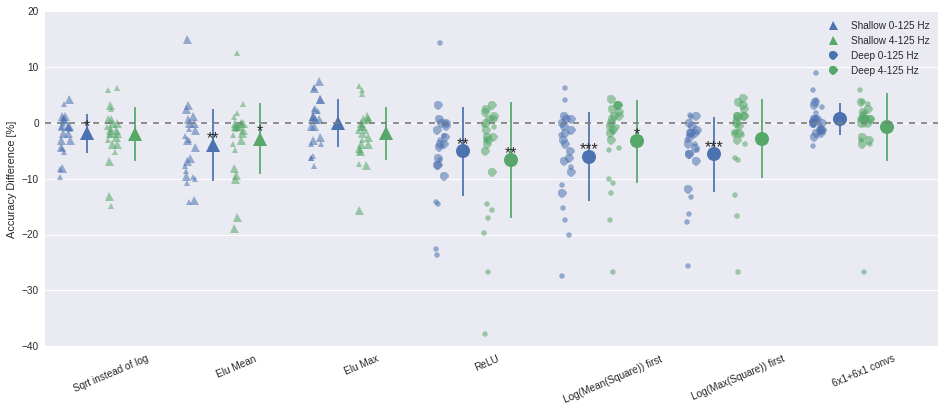

In [322]:
plt.figure(figsize=(16,6))
offset = 0
for i_var, var_name in enumerate(uncommon_variants):
    for freq in [">0", ">4"]:
        for net in 'shallow', 'deep5':
            if net == 'shallow' and var_name in other_deep_vars:
                continue
            if net == 'deep5' and var_name in other_shallow_vars:
                continue
            markersize = 10
            if net == 'deep5':
                marker = 'o'
            else:
                assert net == 'shallow'
                marker = '^'
            if '>0' == freq:
                color = seaborn.color_palette()[0]
            elif '>4' == freq:
                color = seaborn.color_palette()[1]
            this_var = df_mod[(df_mod.variant == var_name) &
                             (df_mod.net == net) & 
                             (df_mod.freq == freq) & 
                             (df_mod.dataset == 'combined')]
            
            baseline_test = this_var.test_baseline_subjects[0]
            var_test = this_var.test_variant_subjects[0]
            diffs = var_test - baseline_test
            assert clean_mod_compare
            plt.plot(rands[:14] * 0.05 + offset - 0.375,
                    diffs[:14], color=color, marker=marker, alpha=0.55, linestyle='None',
                    markersize=9) #markersize 8
            plt.plot(rands[14:] * 0.05 + offset - 0.375,
                    diffs[14:], color=color, marker=marker, alpha=0.55, linestyle='None',
                    markersize=5.5)
            plt.errorbar(offset, this_var['diff'][0], color=color,
                         yerr=this_var['std'][0], marker=marker,
                        markersize=14, label='dummy')
            if this_var['rand'][0] < 0.05:
                significance_str = '*'
                if this_var['rand'][0] < 0.01:
                    significance_str = '**'
                if this_var['rand'][0] < 0.001:
                    significance_str = '***'
                plt.annotate(
                        significance_str, xy = (offset, this_var['diff'][0]),
                    xytext = (0, 15), fontsize=16,
                        textcoords = 'offset points', ha = 'center', va = 'top',)
            offset += 0.6
        offset += 0.2
    offset += 0.5
#plt.ylim(-20,10)
plt.axhline(y=0, color='grey', linestyle='dashed')

plt.xticks(np.arange(0.4,15,2.1), uncommon_variants, rotation=23)
plt.grid('off', axis='x')
plt.xlim(-0.7, plt.xlim()[1]+0.25)
plt.ylabel('Accuracy Difference [%]')

# get handles
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
# recreate  with empty line, only marker
handles = [Line2D([0], [0], color=h[0].get_color(), marker=h[0].get_marker(),
                 markersize=9, linewidth=0) for h in handles]
# use them in the legend
ax.legend(handles[:2] + handles[6:8], ('Shallow 0-125 Hz', 'Shallow 4-125 Hz', 'Deep 0-125 Hz','Deep 4-125 Hz'), 
          bbox_to_anchor=(1,1))


## FFT Net

In [87]:
df_deep_epo_fft_bcic = load_data_frame('data/models/paper/bci-competition/epo/deep-fft/', shorten_headers=False)
df_deep_epo_fft_ours = load_data_frame('data/models/paper/ours/epo/deep-fft/', shorten_headers=False)
only_clean_sets = True
if only_clean_sets:
    df_deep_epo_fft_ours = clean_datasets(df_deep_epo_fft_ours)

IndexError: list index out of range

In [ ]:
all_df_fft = pd.DataFrame()
all_df_fft_comp = pd.DataFrame()

dff = df_deep_epo_fft_bcic
main_csp_bcic = restrict_or_unset(csp_above_0(df_csp_bcic), standardize=False,
                                                                   standardize_cnt=False)



dff = dff.replace({'high_cut_hz': {'undefined': '-'}})
for col in ('rejection_blink_ival', 'rejection_var_ival',
           'num_split_folds', 'whisker_percent',
           'whisker_length', 'eog_sensors', 'layer_modifier',
           'i_test_fold', 'batch_modifier', 'num_filters_simple',
           'filter_length_4', 'final_nonlin', 'max_min'):
    dff[col] = '-'
dff = dff[(dff.num_filters_time == 25) & 
         (dff.norm_axes == '-') &
         (dff.preprocessor == 'null') &
         (dff.filter_length_2 == 3) &
         (dff.final_pool_time_length == '-') &
         ((dff.layers == 'deep_fft_net_spat_time_freq')) &
         (dff.frequency_end != 36) &
         (dff.frequency_start != 4) &
         (dff.include_phase == False) &
         (dff.square_amplitude == False) &
         (dff.tag != 'repl')]

dff.tag = '-'

all_df_fft = pd.concat((all_df_fft, dff))

for freq in ['0-40', '0-124']:
    if freq == '0-40':
        this_dfn = dff[dff.frequency_end == 40]
        df_comp = compare_csp_net(this_dfn, main_csp_bcic,
                                  'fft','0-40','bcic',)
    else:
        this_dfn = dff[dff.frequency_end == 'null']
        assert freq == '0-124'
        df_comp = compare_csp_net(this_dfn, main_csp_bcic,
                                  'fft','0-124','bcic')
    all_df_fft_comp = pd.concat((all_df_fft_comp, df_comp))


        
dataset_averaged_frame(remove_columns_with_same_value(dff))

In [ ]:
dff = df_deep_epo_fft_ours

dff = dff.replace({'high_cut_hz': {'undefined': '-'}})
for col in ('rejection_blink_ival', 'rejection_var_ival',
           'num_split_folds', 'whisker_percent',
           'whisker_length', 'eog_sensors', 'layer_modifier',
           'i_test_fold', 'batch_modifier', 'num_filters_simple',
           'filter_length_4', 'final_nonlin', 'max_min'):
    dff[col] = '-'

main_csp_ours = restrict_or_unset(clean_datasets(csp_above_0(df_csp_ours)), standardize=False,
                                                                   standardize_cnt=False)
dff = dff[(dff.num_filters_time == 25) & 
         (dff.preprocessor == 'null') &
         (dff.filter_length_2 == 3) &
         ((dff.layers == 'deep_fft_net_spat_time_freq') | (dff.layers == 'seperated_linear')) &
         (dff.include_phase == False) &
         (dff.square_amplitude == False)]
if 'norm_axes' in dff.columns:
    dff = dff[(dff.norm_axes == '-')]
if 'final_pool_time_length' in dff.columns:
    dff = dff[(dff.final_pool_time_length == '-')]

    
all_df_fft = pd.concat((all_df_fft, dff))

for freq in ['0-40', '0-124']:
    if freq == '0-40':
        this_dfn = dff[dff.frequency_end == 40]
        df_comp = compare_csp_net(this_dfn, main_csp_ours,
                                  'fft','0-40','ours',)
    else:
        this_dfn = dff[dff.frequency_end == 'null']
        assert freq == '0-124'
        df_comp = compare_csp_net(this_dfn, main_csp_ours,
                                  'fft','0-124','ours')
    all_df_fft_comp = pd.concat((all_df_fft_comp, df_comp))
    
dataset_averaged_frame(remove_columns_with_same_value(dff))

#### add combined

In [ ]:
for freq in ['0-40', '0-124']:
    if freq == '0-40':
        this_dfn = all_df_fft[all_df_fft.frequency_end == 40]
        df_comp = compare_csp_net(this_dfn, 
                                  csp_above_0(pd.concat((main_csp_ours, main_csp_bcic))),
                                  'fft', '0-40', 'combined',)
    else:
        this_dfn = all_df_fft[all_df_fft.frequency_end == 'null']
        assert freq == '0-124'
        df_comp = compare_csp_net(this_dfn,
                                  csp_above_0(pd.concat((main_csp_ours, main_csp_bcic))),
                                  'fft', '0-124', 'combined')
    all_df_fft_comp = pd.concat((all_df_fft_comp, df_comp))

In [ ]:
all_df_fft_comp

In [ ]:
_, fft_model = load_exp_and_model('data/models/paper/ours/epo/deep-fft/22')

In [ ]:
print_layers(fft_model)

### Residual Net

In [ ]:
from braindecode.experiments.load import load_exp_and_model

In [ ]:
exp, model = load_exp_and_model('data/models/paper/ours/cnt/resnet/2')

In [ ]:
from braindecode.veganlasagne.layer_util import print_layers

In [ ]:
from braindecode.veganlasagne.layers import get_n_sample_preds

In [ ]:
get_n_sample_preds(model)

In [ ]:
print_layers(model)

In [ ]:
df_resnet_bcic = load_data_frame('data/models/paper/bci-competition/cnt/resnet/', params=dict(whisker_percent=None),
                            shorten_headers=False)
df_resnet_bcic = df_resnet_bcic[df_resnet_bcic.nonlinearity != '-']
df_resnet_bcic = df_resnet_bcic.drop('final_nonlin', axis=1)
df_resnet_bcic = df_resnet_bcic.drop('batch_modifier', axis=1)

df_resnet_bcic = df_resnet_bcic.replace(dict(survival_prob={'-': 1}, final_aggregator={'-': 'pool'}, 
                                 drop_before_pool={'-': 'False'},
                                split_first_layer={'-': False}))

df_resnet_bcic = df_resnet_bcic[df_resnet_bcic.final_aggregator == 'pool']
df_resnet_bcic = df_resnet_bcic[df_resnet_bcic.split_first_layer == True]
df_resnet_bcic = df_resnet_bcic[df_resnet_bcic.reduction_method == '-']

df_resnet_bcic = remove_columns_with_same_value(df_resnet_bcic)
averaged_frame = dataset_averaged_frame(df_resnet_bcic)


In [ ]:
def no_bp_meaner(df):
    return df[df.batch_modifier != 'bp_meaner']

In [ ]:
compare_csp_net(df_resnet_bcic,
                restrict(no_bp_meaner(tied_loss(deep_5_new_default(above_0(elu_deep_5(df_deep_cnt_bcic))))),
                         max_increasing_epochs=80, trial_start=1500), 
                'resnet','>0','bcic')

In [ ]:
clean_resnet = True
df_resnet_ours = load_data_frame('data/models/paper/ours/cnt/resnet/', params=dict(whisker_percent=None),
                            shorten_headers=False)
if clean_resnet:
    df_resnet_ours = clean_datasets(df_resnet_ours)
df_resnet_ours = df_resnet_ours[df_resnet_ours.nonlinearity != '-']
df_resnet_ours = df_resnet_ours[df_resnet_ours.split_first_layer == True]
#df_resnet_ours = df_resnet_ours[df_resnet_ours.reduction_method == '-']

averaged_frame = dataset_averaged_frame(remove_columns_with_same_value(df_resnet_ours))
averaged_frame

In [ ]:
df_resnet_ours = df_resnet_ours[df_resnet_ours.reduction_pool_mode == 'null']
df_resnet_ours = df_resnet_ours[df_resnet_ours.add_after_nonlin == False]
df_resnet_ours = df_resnet_ours[df_resnet_ours.low_cut_off_hz == 'null']
compare_csp_net(df_resnet_ours,
                restrict(no_bp_meaner(tied_loss(deep_5_new_default(above_0(elu_deep_5(
                            clean_datasets(df_deep_cnt_ours)))))),
                         max_increasing_epochs=80, trial_start=1500),
                'resnet','>0','ours')

In [ ]:
compare_csp_net(pd.concat((df_resnet_bcic,df_resnet_ours)),
                restrict(pd.concat((
            no_bp_meaner(tied_loss(deep_5_new_default(above_0(elu_deep_5(df_deep_cnt_bcic))))),
            no_bp_meaner(tied_loss(deep_5_new_default(above_0(elu_deep_5(clean_datasets(df_deep_cnt_ours)))))))),
                         max_increasing_epochs=80, trial_start=1500),
                'resnet','>0','combined')

### Training TImes

In [ ]:

df_csp_ours = load_data_frame('data/models/paper/ours/csp/', shorten_headers=False)
df_csp_bcic = load_data_frame('data/models/paper/bci-competition/csp/', shorten_headers=False)

In [ ]:
from IPython.display import display_html, display, HTML
from braindecode.analysis.pandas_util import dataset_averaged_frame, remove_columns_with_same_value, load_data_frame

In [ ]:
def display_bci_competition_times(folder):
    display(HTML("<h5>Shallow</h5>"))
    display_html(dataset_averaged_frame(remove_columns_with_same_value(
        clean_datasets(load_data_frame('data/models/paper/bci-competition/cnt/shallow/{:s}/'.format(folder),
                                  shorten_headers=False)))))
    display(HTML("<h5>Deep</h5>"))
    display_html(dataset_averaged_frame(remove_columns_with_same_value(
        clean_datasets(load_data_frame('data/models/paper/bci-competition/cnt/deep4/{:s}/'.format(folder),
                                  shorten_headers=False)))))
    
def display_ours_times(folder):
    display(HTML("<h5>Shallow</h5>"))
    display_html(dataset_averaged_frame(remove_columns_with_same_value(
        clean_datasets(load_data_frame('data/models/paper/ours-before-cz-0/cnt/shallow/{:s}/'.format(folder),
                                  shorten_headers=False)))))
    display(HTML("<h5>Deep</h5>"))
    display_html(dataset_averaged_frame(remove_columns_with_same_value(
        clean_datasets(load_data_frame('data/models/paper/ours-before-cz-0/cnt/deep4/{:s}/'.format(folder),
                                  shorten_headers=False)))))

#### BCI Competition

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(csp_above_0(df_csp_bcic)))

In [ ]:
display_bci_competition_times('traintime-rz')

In [ ]:
display_bci_competition_times('traintime-tf')

#### Ours

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(csp_above_0(df_csp_ours)))

In [ ]:
dataset_averaged_frame(all_df[(all_df.dataset =='ours') &
                             (all_df.clean == False)
                             ])

In [ ]:
display_ours_times('traintime-rz')

In [ ]:
display_ours_times('traintime-tf')

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(
    clean_datasets(load_data_frame('data/models/paper/ours/cnt/shallow/traintime-rz/',
                                  shorten_headers=False))))

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(
    clean_datasets(load_data_frame('data/models/paper/ours/cnt/deep4/traintime-rz/',
                                  shorten_headers=False))))

### Old trianing times, unclear which queue

In [ ]:
dfn = restrict(shallow_cnt_default(tied_loss(above_0(square_shallow(df_shallow_cnt_bcic)))), drop_p='-')
dataset_averaged_frame(remove_columns_with_same_value(dfn))

In [ ]:
dfn = no_bp_meaner(tied_loss(deep_5_new_default(above_0(elu_deep_5(df_deep_cnt_bcic)))))
dataset_averaged_frame(remove_columns_with_same_value(dfn))

In [ ]:
dfn = restrict(shallow_cnt_default(tied_loss(above_0(square_shallow(df_shallow_cnt_ours)))), drop_p='-', tag='repl')
dataset_averaged_frame(remove_columns_with_same_value(dfn))

In [ ]:
dfn = no_bp_meaner(tied_loss(deep_5_new_default(above_0(elu_deep_5(df_deep_cnt_ours)))))
dataset_averaged_frame(remove_columns_with_same_value(dfn))

### New ours Run

In [ ]:
remove_columns_with_same_value(load_data_frame('data/models/paper/ours-before-cz-0/csp/car/'))

In [ ]:
df_deep_ours_new = load_data_frame('data/models/paper/ours/cnt/deep5/', shorten_headers=False)

In [ ]:
avgd = dataset_averaged_frame(remove_columns_with_same_value(df_deep_ours_new))

In [ ]:
df_shallow_ours_new = load_data_frame('data/models/paper/ours/cnt/shallow/', shorten_headers=False)

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(df_shallow_ours_new))

In [ ]:
def strfdelta(tdelta, fmt):
    """For numpy timedelta, modified from
    http://stackoverflow.com/a/8907269/1469195"""
    d = {"days": tdelta.astype('timedelta64[D]').astype(np.int32)}
    # only those seconds not absorbed by day
    seconds = tdelta.astype('timedelta64[s]').astype(np.int32) % (3600 * 24)
   
    d["hours"], rem = divmod(seconds, 3600)
    d["minutes"], d["seconds"] = divmod(rem, 60)
    return fmt.format(**d)

In [ ]:
time_lens = np.array(avgd['time', 'len'])
time_means = np.array(avgd['time', 'tmean'])

n_open_exps_per_variant = 20 - time_lens
n_open_exps = np.sum(n_open_exps_per_variant)
remaining_time_per_variant = n_open_exps_per_variant * time_means

avg_time_per_exp = np.sum(time_means * time_lens) / float(np.sum(time_lens))
total_time = n_open_exps * avg_time_per_exp
print strfdelta(np.sum(remaining_time_per_variant) / 14.0, "{days} days {hours}:{minutes}:{seconds}")

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(load_data_frame('data/models/paper/ours/epo/shallow//')))

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(load_data_frame('data/models/paper/ours/epo/deep4/')))

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(df_csp_ours))

In [ ]:
df_shallow_wanted = tied_loss(square_shallow(shallow_cnt_default(yes_drop(yes_bnorm(above_4(df_clean))))))

In [ ]:
df_shallow_wanted = remove_columns_with_same_value(df_shallow_wanted)

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(df_shallow_wanted))

In [ ]:
df_csp_wanted = remove_columns_with_same_value(csp_above_4(df_csp_ours_clean))

In [ ]:
dataset_averaged_frame(df_csp_wanted)

In [ ]:
compare_csp_net(df_shallow_wanted, df_csp_wanted,'shallow', '4', 'ours',with_csp_acc=True,with_std=True,
               with_std_error=True)

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(df_csp_ours_clean))

In [ ]:
df_clean = df_shallow_ours_new.copy()
df_csp_ours_clean = df_csp_ours.copy
for name in unclean_sets:
    df_clean = df_clean[np.logical_not(df_clean.dataset_filename.str.contains(name))]
    df_csp_ours_clean = df_csp_ours_clean[np.logical_not(df_csp_ours_clean.dataset_filename.str.contains(name))]
dataset_averaged_frame(remove_columns_with_same_value(df_clean))
    

In [ ]:

df_csp_ours = load_data_frame('data/models/paper/ours/csp/', shorten_headers=False)

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(df_csp_ours))

In [ ]:
df_clean_csp = df_csp_ours.copy()
for name in unclean_sets:
    df_clean_csp = df_clean_csp[np.logical_not(df_clean_csp.dataset_filename.str.contains(name))]
dataset_averaged_frame(remove_columns_with_same_value(df_clean_csp))
    

### Compare with more epochs

In [ ]:
param_keys

In [ ]:
df_ours = df_shallow_cnt_ours

param_keys = df_ours.columns

param_keys = set(param_keys) - set(['test', 'train', 'time', 'max_epochs', 'max_increasing_epochs'])

df_long = df_ours[df_ours.max_increasing_epochs == 160]
df_quick = df_ours[df_ours.max_increasing_epochs == 80]

df_merged = df_long.merge(df_quick, on=list(param_keys), suffixes=('_long', '_quick'))

plt.plot(df_merged.test_long - df_merged.test_quick)
plt.axhline(y=0, color='k')
print np.mean(df_merged.test_long - df_merged.test_quick)

In [ ]:
df_ours = df_deep_cnt_ours

param_keys = df_ours.columns

param_keys = set(param_keys) - set(['test', 'train', 'time', 'max_epochs', 'max_increasing_epochs'])

df_long = df_ours[df_ours.max_increasing_epochs == 160]
df_quick = df_ours[df_ours.max_increasing_epochs == 80]

df_merged = df_long.merge(df_quick, on=list(param_keys), suffixes=('_long', '_quick'))

plt.plot(df_merged.test_long - df_merged.test_quick)
plt.axhline(y=0, color='k')
print np.mean(df_merged.test_long - df_merged.test_quick)

### Vs different trials

In [ ]:
df_ours = df_shallow_cnt_ours

param_keys = df_ours.columns

param_keys = set(param_keys) - set(['test', 'train', 'time', 'max_epochs', 'max_increasing_epochs', 'trial_start'])

df_long = df_ours[df_ours.trial_start == 2000]
df_quick = df_ours[df_ours.max_increasing_epochs == 80]

df_merged = df_long.merge(df_quick, on=list(param_keys), suffixes=('_long', '_quick'))

plt.plot(df_merged.test_long - df_merged.test_quick)
plt.axhline(y=0, color='k')
print np.mean(df_merged.test_long - df_merged.test_quick)

In [ ]:
df_ours = df_deep_cnt_ours

param_keys = df_ours.columns

param_keys = set(param_keys) - set(['test', 'train', 'time', 'max_epochs', 'max_increasing_epochs', 'trial_start'])

df_long = df_ours[df_ours.trial_start == 2000]
df_quick = df_ours[df_ours.max_increasing_epochs == 80]

df_merged = df_long.merge(df_quick, on=list(param_keys), suffixes=('_long', '_quick'))

plt.plot(df_merged.test_long - df_merged.test_quick)
plt.axhline(y=0, color='k')
print np.mean(df_merged.test_long - df_merged.test_quick)

### BCI competition CSP with >0 Hz

In [ ]:

df_csp_bcic = load_data_frame('data/models/paper/bci-competition/csp/', shorten_headers=False)

In [ ]:
dfc = df_csp_bcic
dfc = dfc[dfc.min_freq == 1.0]
dataset_averaged_frame(remove_columns_with_same_value(dfc)).sort_values(('test', 'mean'),ascending=False)

In [ ]:

df_csp_ours = load_data_frame('data/models/paper/ours/csp/', shorten_headers=False)

In [ ]:
dfc = df_csp_ours
dfc = dfc[dfc.min_freq == 1.0]
dataset_averaged_frame(remove_columns_with_same_value(dfc)).sort_values(('test', 'mean'),ascending=False)